---
title: "Fraud Detection"
author: "Simon Chiu"
date: last-modified
execute: 
  warning: false
---

# 1. Tasks

This data analytics project revolves around enhancing fraud detection in online financial transactions, a critical business use case vital for both consumers and businesses. The significance lies in the escalating threat of fraudulent activities within e-commerce, leading to substantial financial losses for businesses and potential security risks for consumers. 

Our primary focus is to leverage a comprehensive dataset sourced from Vesta Corporation, a leading payment service company, to develop and refine machine learning models aimed at accurately distinguishing between legitimate and fraudulent transactions.

The original evaluation metric for this Kaggle competition is ROC AUC; however, due to the imbalance data problem (shown in isFruad section), I think it's better to use Precision-Recall Curve AUC as the evaluation metric. Let's talk about why.

## ROC Curve

<table><tr>
<td> <img src="image/roc_curve.png" width="300" height="300"> </td>
<td> <img src="image/tpr_tnr.png" width="400" height="300"> </td>
</tr></table>

ROC curve uses True Positive Rate (TPR) and True Negative Rate (TNR) as y-axis and x-axis. 

TPR indicates the model's ability to distinguish postive data; TNR indicates the model's ability to distinguish negative data. Thus, ROC curve shows the overall ability to distinguish postive and negative classes.

However, in imbalance dataset with small amount of TP, TNR is not what we care about.

## Precision-Recall Curve

<table><tr>
<td> <img src="image/precision_recall_curve.png" width="300" height="300"> </td>
<td> <img src="image/precision_recall.png" width="500" height="300"> </td>
</tr></table>

Precision-Recall curve uses Precision and Recall as y-axis and x-axis. 

Recall indicates the model's ability to distinguish postive data; Precision indicates how many of the predicted positive cases are actually positive. Thus, Precision-Recall curve shows the overall ability to find as many as positive cases and also with a precise prediction.

Given our imbalanced dataset with a small number of TP and considering the real-world scenario of monitoring fraudulent transactions, utilizing the Precision-Recall curve would be prudent as it specifically emphasizes TP.

# 2. Import Packages

In [1]:
#| code-fold: true
#| output: false
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#| code-fold: true
#| output: false

#for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier 

from xgboost import XGBClassifier
import xgboost as xgb

# for hyperparameter tunning
from hyperopt import hp
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [3]:
#| code-fold: true
#| output: false
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# 3. Predefined Functions

In [4]:
#| code-fold: true
#| output: false

# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


#summary of the dataframe
def resumetable(df, columns):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df[columns].dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df[columns].isnull().sum().values
    summary['Uniques'] = df[columns].nunique().values
    summary['First Value'] = df[columns].iloc[0].values
    summary['Second Value'] = df[columns].iloc[1].values
    summary['Third Value'] = df[columns].iloc[2].values    
    return summary

#plot two charts to perform in-depth analysis on different categorical columns
#The top section (subplot 1) presents a count plot, illustrating the frequency of occurrences for each category and the corresponding percentage of fraudulent transactions. The bottom section (subplot 2) offers a bar plot depicting the total transaction amounts across different categories, coupled with the percentage of fraudulent transaction amounts. 
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black')
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("% Fraud Transactions", fontsize=16)
    g.set_title(f"Count of {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel(f"Count of {col}", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black')
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("% Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"Transaction Amount by {col} + % Fraud Transactions Amount", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount (US$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
# calculate missing value percentage for a column
def calculate_missing_percentage(df, column_name):
    missing_values = df[column_name].isnull().sum()
    total_rows = df.shape[0]
    missing_pct = round(missing_values / total_rows * 100, 2)
    print(f"Missing value percentage for {column_name}: {missing_pct}%")


In [5]:
#| code-fold: true
# For modeling

# group low frequency categorical values to avoid high dimensionality after performing one hot encoding
def group_low_percentage_values(df, column, threshold=1, new_category='others'):
    result = df[column].value_counts(normalize=True) * 100
    values_to_group = result[result < threshold].index.tolist()
    df[column] = df[column].apply(lambda x: new_category if x in values_to_group else x)
    return df

# since we're using time related data, it's better to split by date rather than traditional train test split
def split_data_by_date(X_transformed, y, train_date, test_date):
    x_train, y_train = X_transformed.loc[:train_date], y.loc[:train_date]
    x_test, y_test = X_transformed.loc[test_date:], y.loc[test_date:]
    return x_train, y_train, x_test, y_test

# upsampling for minor class
def upsample_minority_class(X, target_column='isFraud', random_state=27):

    not_fraud = X[X[target_column] == 0]
    fraud = X[X[target_column] == 1]

    # Upsample minority class
    fraud_upsampled = resample(fraud,
                              replace=True,
                              n_samples=len(not_fraud),
                              random_state=random_state)

    # Combine majority and upsampled minority
    upsampled = pd.concat([not_fraud, fraud_upsampled])
    
    return upsampled

def evaluate_results(y_true, y_pred):
    # F1 Score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Precision Recall
    # Calculate Precision and Recall
    TN, FP, FN, TP = conf_matrix.ravel()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    print(f"Precision is {round(precision*100)} %; Recall is {round(recall*100)} %")

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_rc_auc = auc(recall, precision)
    print(f"PR-RC AUC: {pr_rc_auc}")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_rc_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
    
    # conclusion
    TP_rate = round(TP/(FN+TP)*100)
    FP_rate = round(FP/(FP+TN)*100)
    precision = TP / (TP + FP)

    print(f"Can capture {TP_rate} % of fraud transactions and the prediction precision is {round(precision*100)} %. {FP_rate} % of non-fraud transactions are misclassified")



# 4. Read Data

In [6]:
transaction = pd.read_csv('data/train_transaction.csv')
identity = pd.read_csv('data/train_identity.csv')

# 5. Columns Descriptions

In [7]:
transaction_cols = list(transaction.columns)
print(transaction_cols)

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

**Transaction columns description**:

-  TransactionDT: timedelta from a given reference datetime (not an actual timestamp), start date = '2017-12-01'
-  TransactionAMT: transaction payment amount in USD
-  ProductCD: product code, the product for each transaction
-  card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
-  addr: address, both addr is for purchaser, addr1 is billing region and addr2 is billing country
-  dist: distance, distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.
-  P_ and (R__) emaildomain: purchaser and recipient email domain
-  C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
-  D1-D15: timedelta, such as days between previous transaction, etc.
-  M1-M9: match, such as names on card and address, etc.
-  Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [8]:
identity_cols = list(identity.columns)
print(identity_cols)

['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


**Identity columns description**:

- id: network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

**Numerous columns, including C1-C14, D1-D15, M1-M9, Vxxx, and id, obscure their true meanings. To derive meaningful business conclusions and recommendations, my focus will be on those explainable columns.**

# 6. EDA

In [9]:
#| code-fold: true

## REducing memory
df_trans = reduce_mem_usage(transaction)
df_id = reduce_mem_usage(identity)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


## 6-1. EDA-Transaction

In [10]:
#| code-fold: true

resumetable(df_trans, df_trans.columns.tolist())[:10]

Dataset Shape: (590540, 394)


Name   dtypes  Missing  Uniques First Value Second Value  \
0   TransactionID    int32        0   590540     2987000      2987001   
1         isFraud     int8        0        2           0            0   
2   TransactionDT    int32        0   573349       86400        86401   
3  TransactionAmt  float16        0     8195        68.5         29.0   
4       ProductCD   object        0        5           W            W   
5           card1    int16        0    13553       13926         2755   
6           card2  float16     8933      500         NaN        404.0   
7           card3  float16     1565      114       150.0        150.0   
8           card4   object     1577        4    discover   mastercard   
9           card5  float16     4259      119       142.0        102.0   

  Third Value  
0     2987002  
1           0  
2       86469  
3        59.0  
4           W  
5        4663  
6       490.0  
7       150.0  
8        visa  
9       166.0

### TransactionID

TransactionID has 590540 unique values, which is the same as df_trans's rows, so that we can confirm TransactionID is a valid primary key.

### isFraud

The fraudulent transactions, both in count and total amount, represent only a small portion of the overall transactions. This suggests an imbalance in the data, which is an issue we should consider when building models.

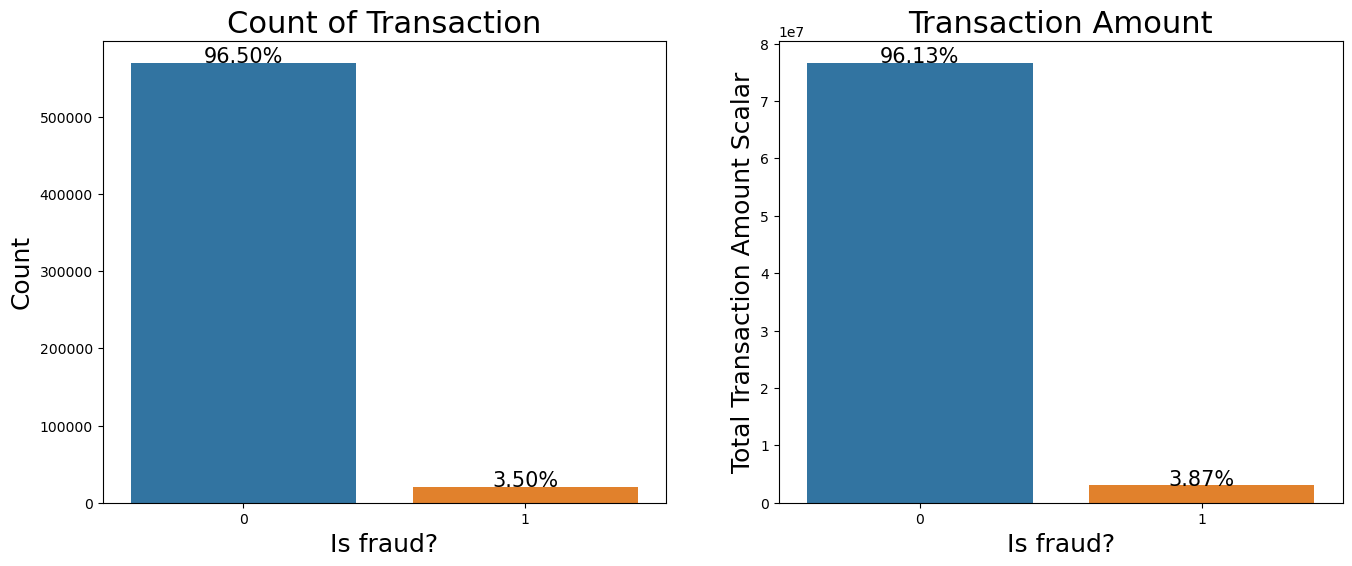

In [11]:
#| code-fold: true

df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Count of Transaction", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("Transaction Amount", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

### TransactionDT

1. Min Date: 2017-12-02 00:00:00, Max Date: 2018-06-01 23:58:51
2. The range of TransactionDT is about half a year
3. Fraudulent transactions are likely associated with Hours

In [12]:
#| code-fold: true

resumetable(df_trans, ["TransactionDT"])

Dataset Shape: (590540, 394)


Name dtypes  Missing  Uniques  First Value  Second Value  \
0  TransactionDT  int32        0   573349        86400         86401   

   Third Value  
0        86469

Looking at the first, second and third value, it appears that the `TransactionDT` is structured in a format resembling a time delta measured in seconds. Let's delve deeper into this for further exploration.

In [13]:
#| code-fold: true

TransactionDT_min = df_trans['TransactionDT'].min()
TransactionDT_max = df_trans['TransactionDT'].max()
convert_to_days = 24*60*60
TransactionDT_range = (TransactionDT_max-TransactionDT_min)/convert_to_days
print(f"Min TransactionDT:{TransactionDT_min}; Max TransactionDT:{TransactionDT_max}")
print(f"TransactionDT Range (days):{TransactionDT_range}")
print("The range of TransactionDT is about half a year.")

Min TransactionDT:86400; Max TransactionDT:15811131
TransactionDT Range (days):181.99920138888888
The range of TransactionDT is about half a year.


In [14]:
#| code-fold: true

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

min_date, max_date = df_trans["Date"].min(), df_trans["Date"].max()
print(f"Min Date: {min_date}, Max Date: {max_date}")

Min Date: 2017-12-02 00:00:00, Max Date: 2018-06-01 23:58:51


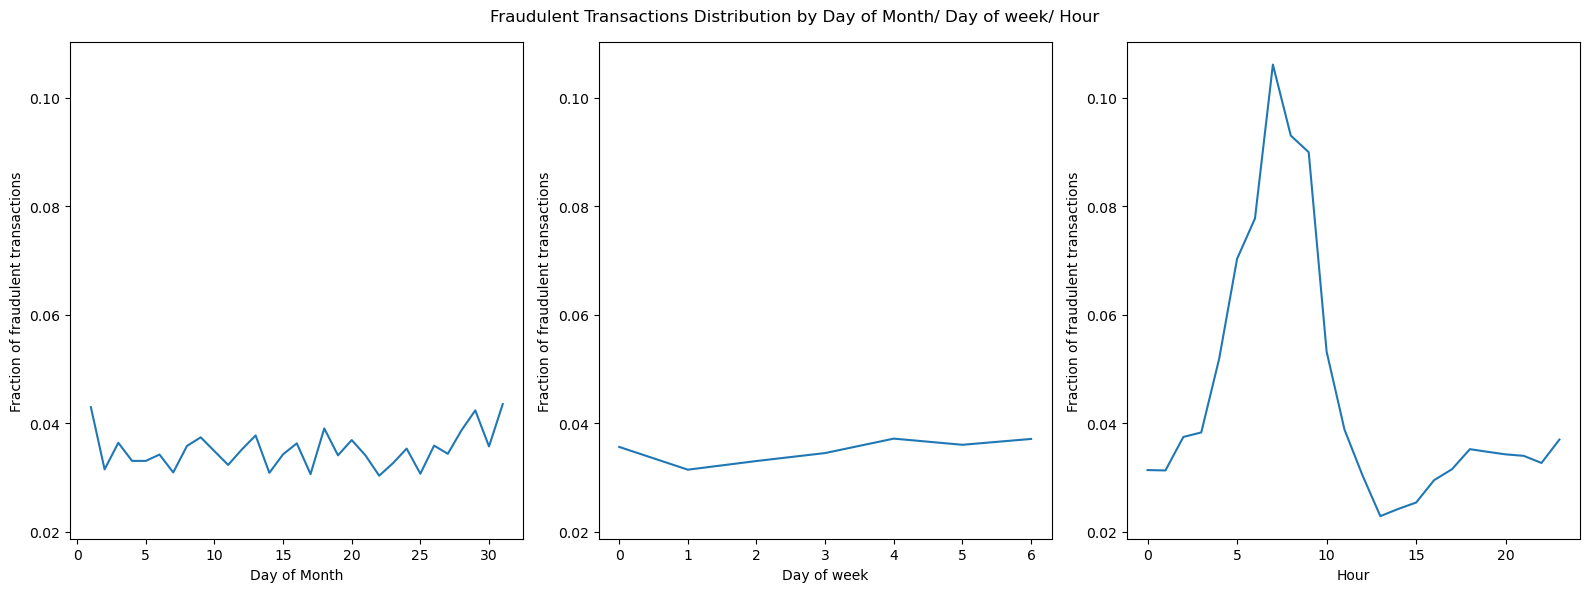

In [15]:
#| code-fold: true

plt.figure(figsize=(16, 6))

# Create subplots with shared y-axis
ax1 = plt.subplot(131)
ax1.plot(df_trans.groupby('_Days').mean()['isFraud'])
ax1.set_xlabel('Day of Month')
ax1.set_ylabel('Fraction of fraudulent transactions')

ax2 = plt.subplot(132, sharey=ax1)
ax2.plot(df_trans.groupby('_Weekdays').mean()['isFraud'])
ax2.set_xlabel('Day of week')
ax2.set_ylabel('Fraction of fraudulent transactions')

ax2 = plt.subplot(133, sharey=ax1)  # Share y-axis with ax1
ax2.plot(df_trans.groupby('_Hours').mean()['isFraud'])
ax2.set_xlabel('Hour')
ax2.set_ylabel('Fraction of fraudulent transactions')

plt.suptitle("Fraudulent Transactions Distribution by Day of Month/ Day of week/ Hour")
plt.tight_layout()

plt.show()

It appears that fraudulent transactions are more closely associated with the hour of the day rather than the day of the week. We can consider this as one of the feature for our model.

### TransactionAmt

1. The distribution of TransactionAmt is quite skewed.
2. After log transfomration, fraud's TransactionAmt is more spread out between Q1 and Q3.
3. After log transformation, Not Fruad has more outliers.

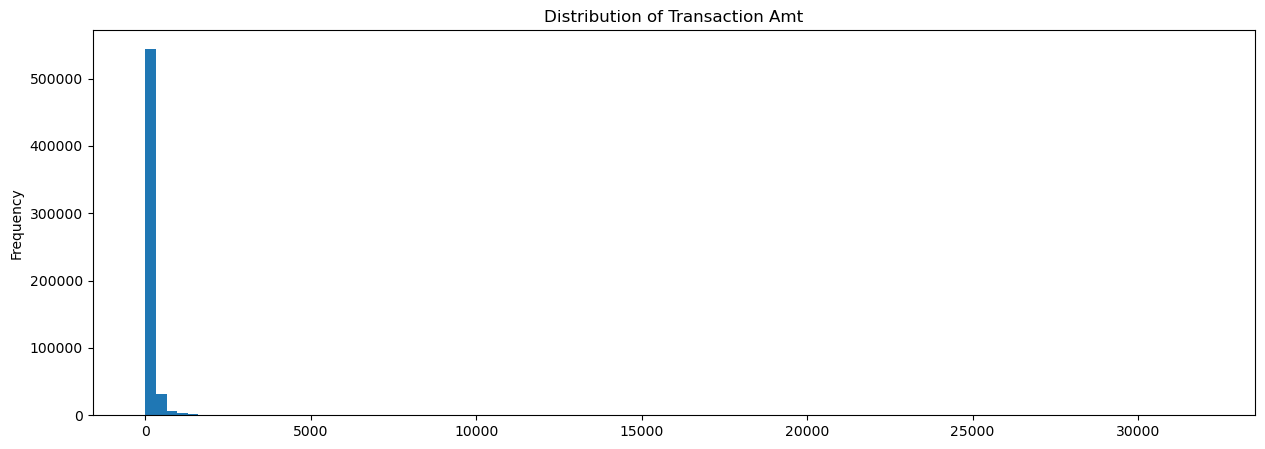

In [16]:
#| code-fold: true

df_trans['TransactionAmt'].plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Transaction Amt')
plt.show()

The distribution of TransactionAmt is quite skewwed, so let's convert it with log transformation

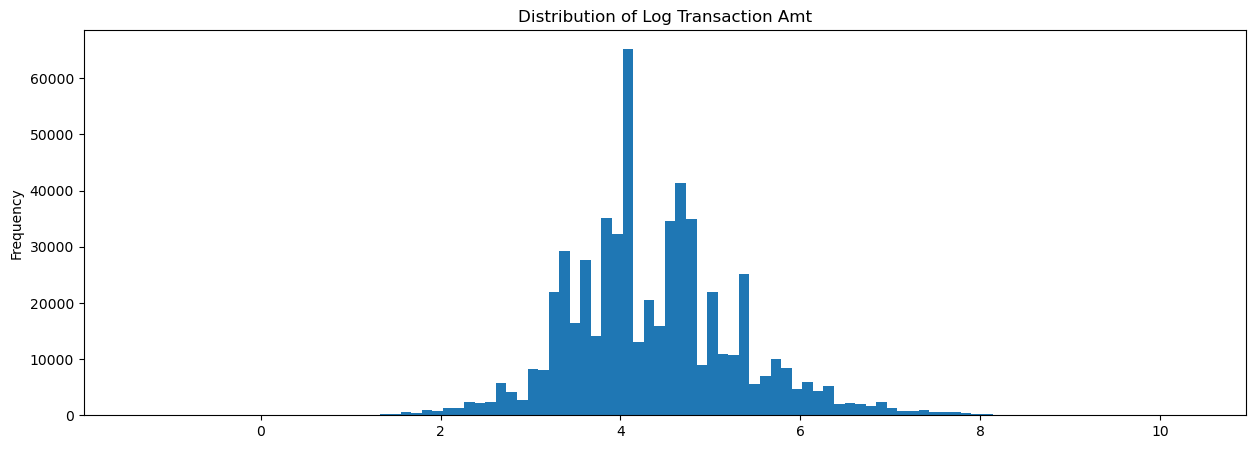

In [17]:
#| code-fold: true

df_trans['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

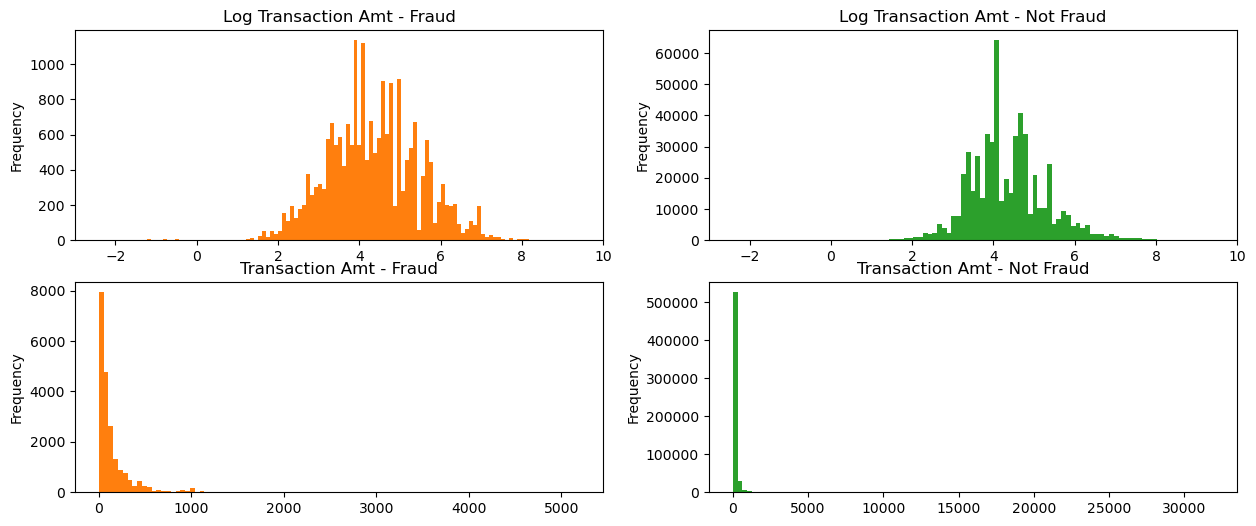

In [18]:
#| code-fold: true

color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
df_trans.loc[df_trans['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
df_trans.loc[df_trans['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
df_trans.loc[df_trans['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
df_trans.loc[df_trans['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)
plt.show()

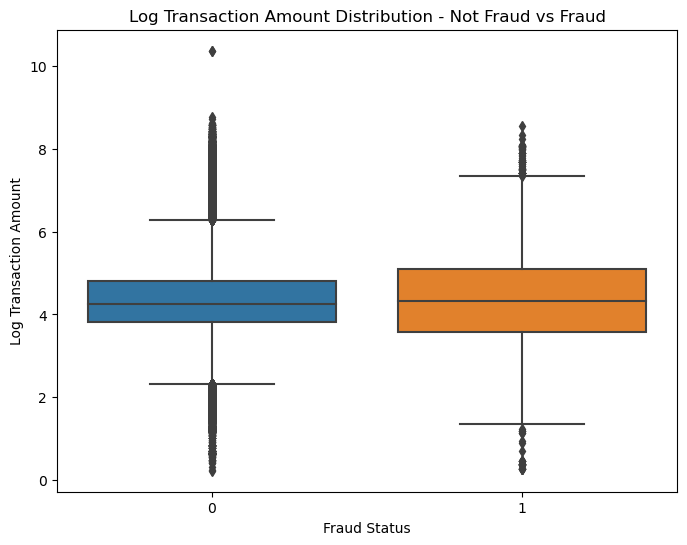

In [19]:
#| code-fold: true

# Apply log transformation to transaction amounts
df_trans['Log_TransactionAmt'] = np.log(df_trans['TransactionAmt'] + 1)  # Adding 1 to avoid log(0)

plt.figure(figsize=(8, 6))

sns.boxplot(x='isFraud', y='Log_TransactionAmt', data=df_trans)
plt.title('Log Transaction Amount Distribution - Not Fraud vs Fraud')
plt.xlabel('Fraud Status')
plt.ylabel('Log Transaction Amount')

plt.show()

### isFraud & TransactionDT & TransactionAmt

1. fraud rate occurs between 4 am to 11 am, characterized by fewer transactions and lower transaction amounts.

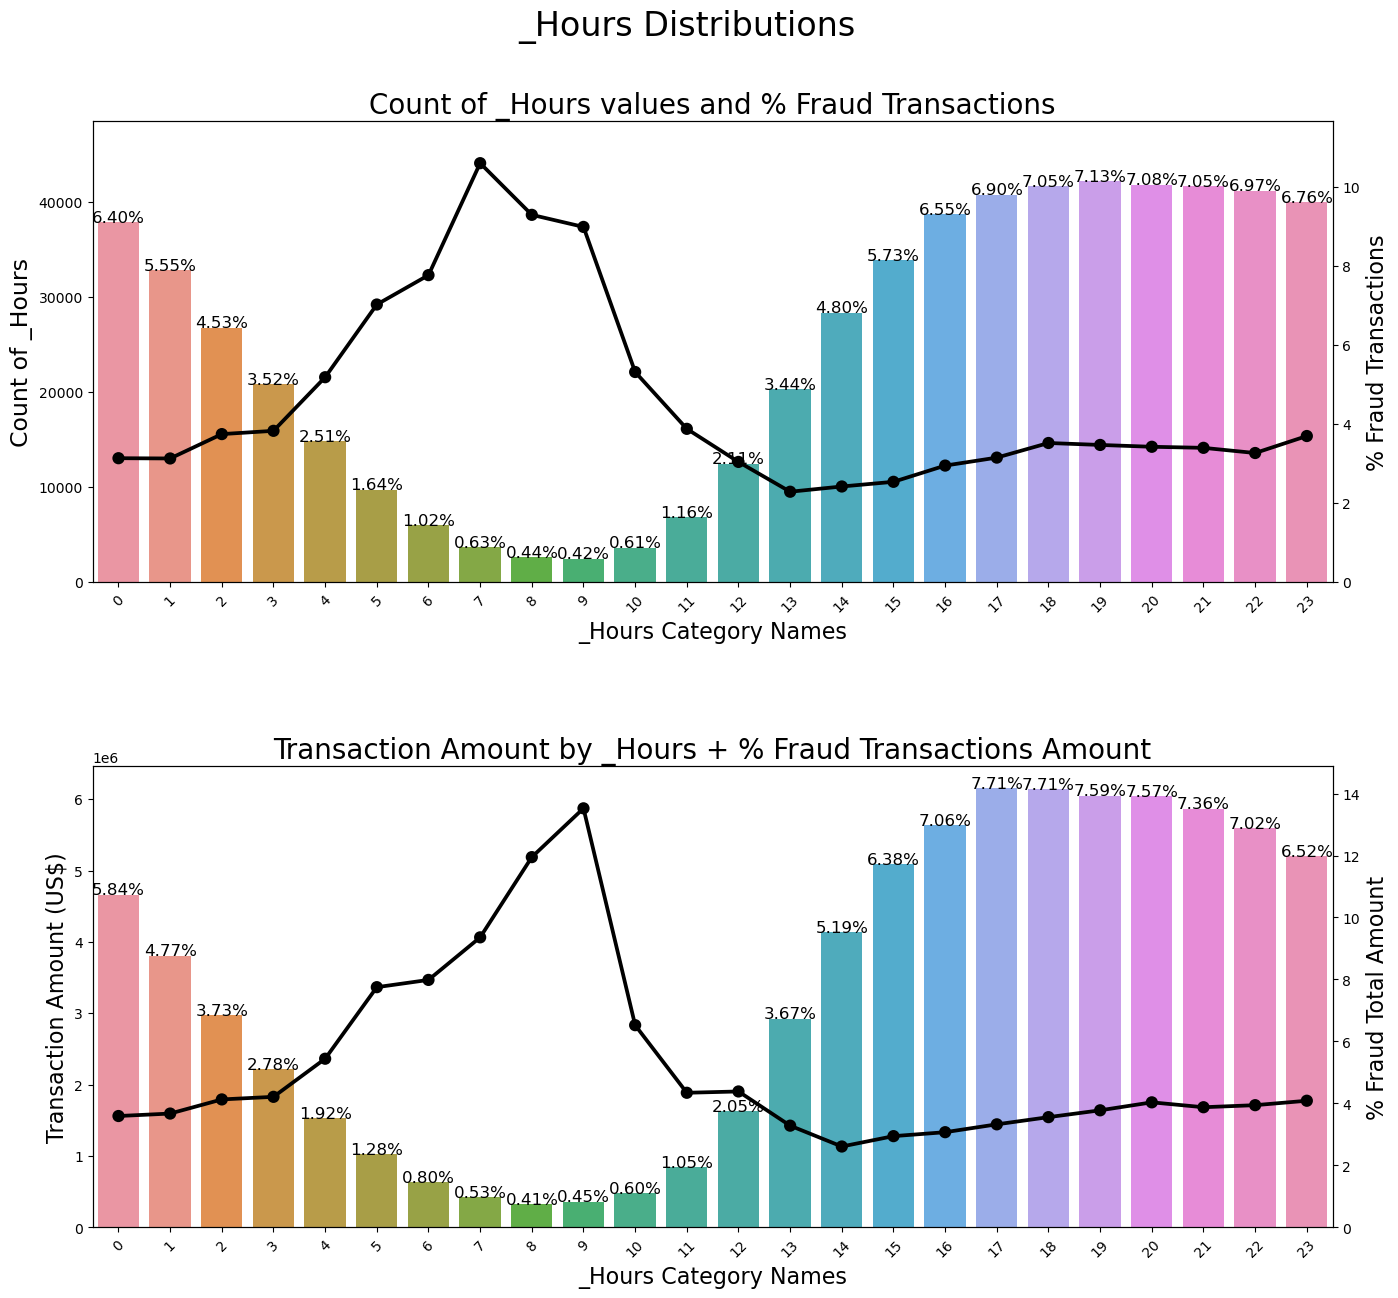

In [20]:
#| code-fold: true

ploting_cnt_amt(df_trans, '_Hours')

When initially analyzing TransactionDT in the previous section, we observed variations in the fraud rate across different hours. Subsequently, examining the two charts above, we identify that the fraud rate occurs between 4 am to 11 am, characterized by fewer transactions and lower transaction amounts.
A plausible business hypothesis could suggest that these types of fraud might originate overseas, potentially in different time zones from the local time.

### isFraud & TransactionDT & ProductCD

1. Product C has the highest fraud rate, which is 6 times than Product W.
2. The main product W has the lowest fraud rate.

In [21]:
#| code-fold: true

resumetable(df_trans, ['ProductCD'])

Dataset Shape: (590540, 399)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  ProductCD  object        0        5           W            W           W

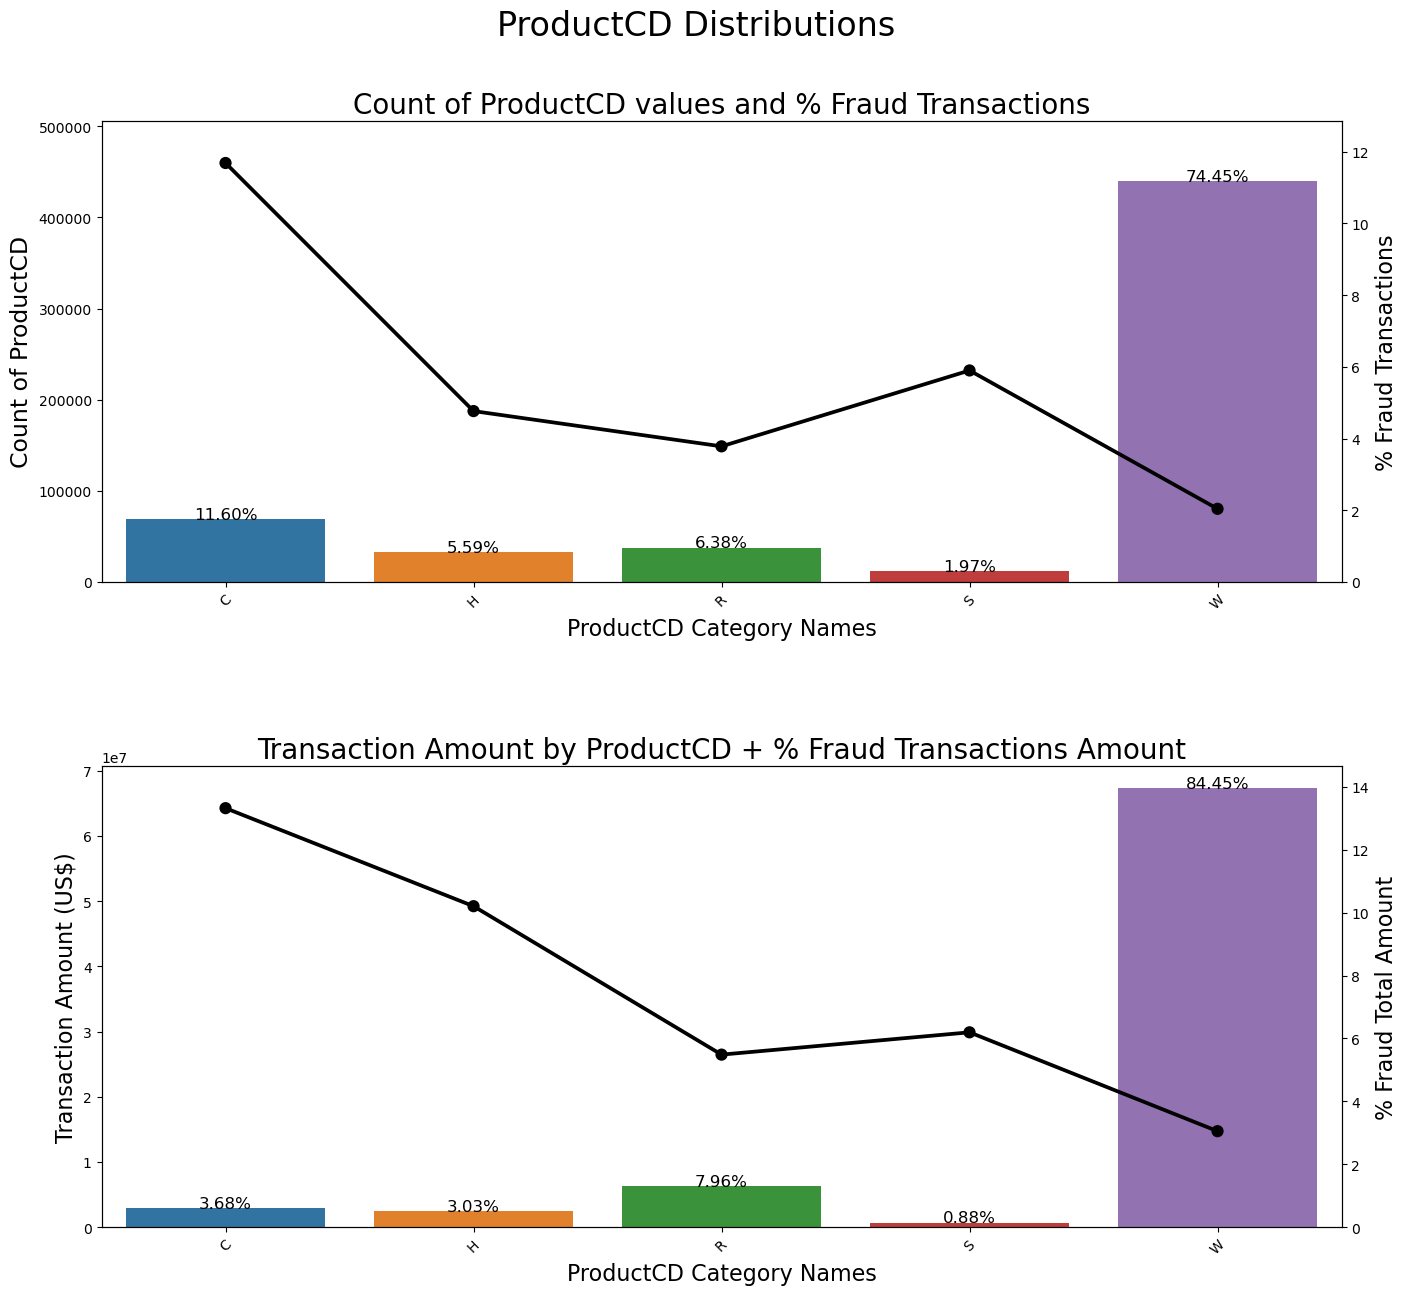

In [22]:
#| code-fold: true

ploting_cnt_amt(df_trans, 'ProductCD')

### Card1-6

- card4 (issuer company):
    1. Visa and Mastercard are the two main issuer companies and these two companies have similar fraudd rate.
    2. Discover has the highest fraud rate.

- card6 (card type):
    1. debit and credit card are the two main types.
    2. credit card is less common but with higher fraud rate.

In [23]:
#| code-fold: true

resumetable(df_trans, ['card1', 'card2', 'card3','card4', 'card5', 'card6'])

Dataset Shape: (590540, 399)


Name   dtypes  Missing  Uniques First Value Second Value Third Value
0  card1    int16        0    13553       13926         2755        4663
1  card2  float16     8933      500         NaN        404.0       490.0
2  card3  float16     1565      114       150.0        150.0       150.0
3  card4   object     1577        4    discover   mastercard        visa
4  card5  float16     4259      119       142.0        102.0       166.0
5  card6   object     1571        4      credit       credit       debit

Out of the provided variables, four are numeric, and two are categorical. As the dataset lacks explicit definitions for the numeric variables, let's concentrate on the categorical ones, which we can infer likely represent the card issuer company and card type.

In [24]:
#| code-fold: true

calculate_missing_percentage(df_trans, 'card4')
df_trans.card4 = df_trans.card4.fillna('NAN')

Missing value percentage for card4: 0.27%


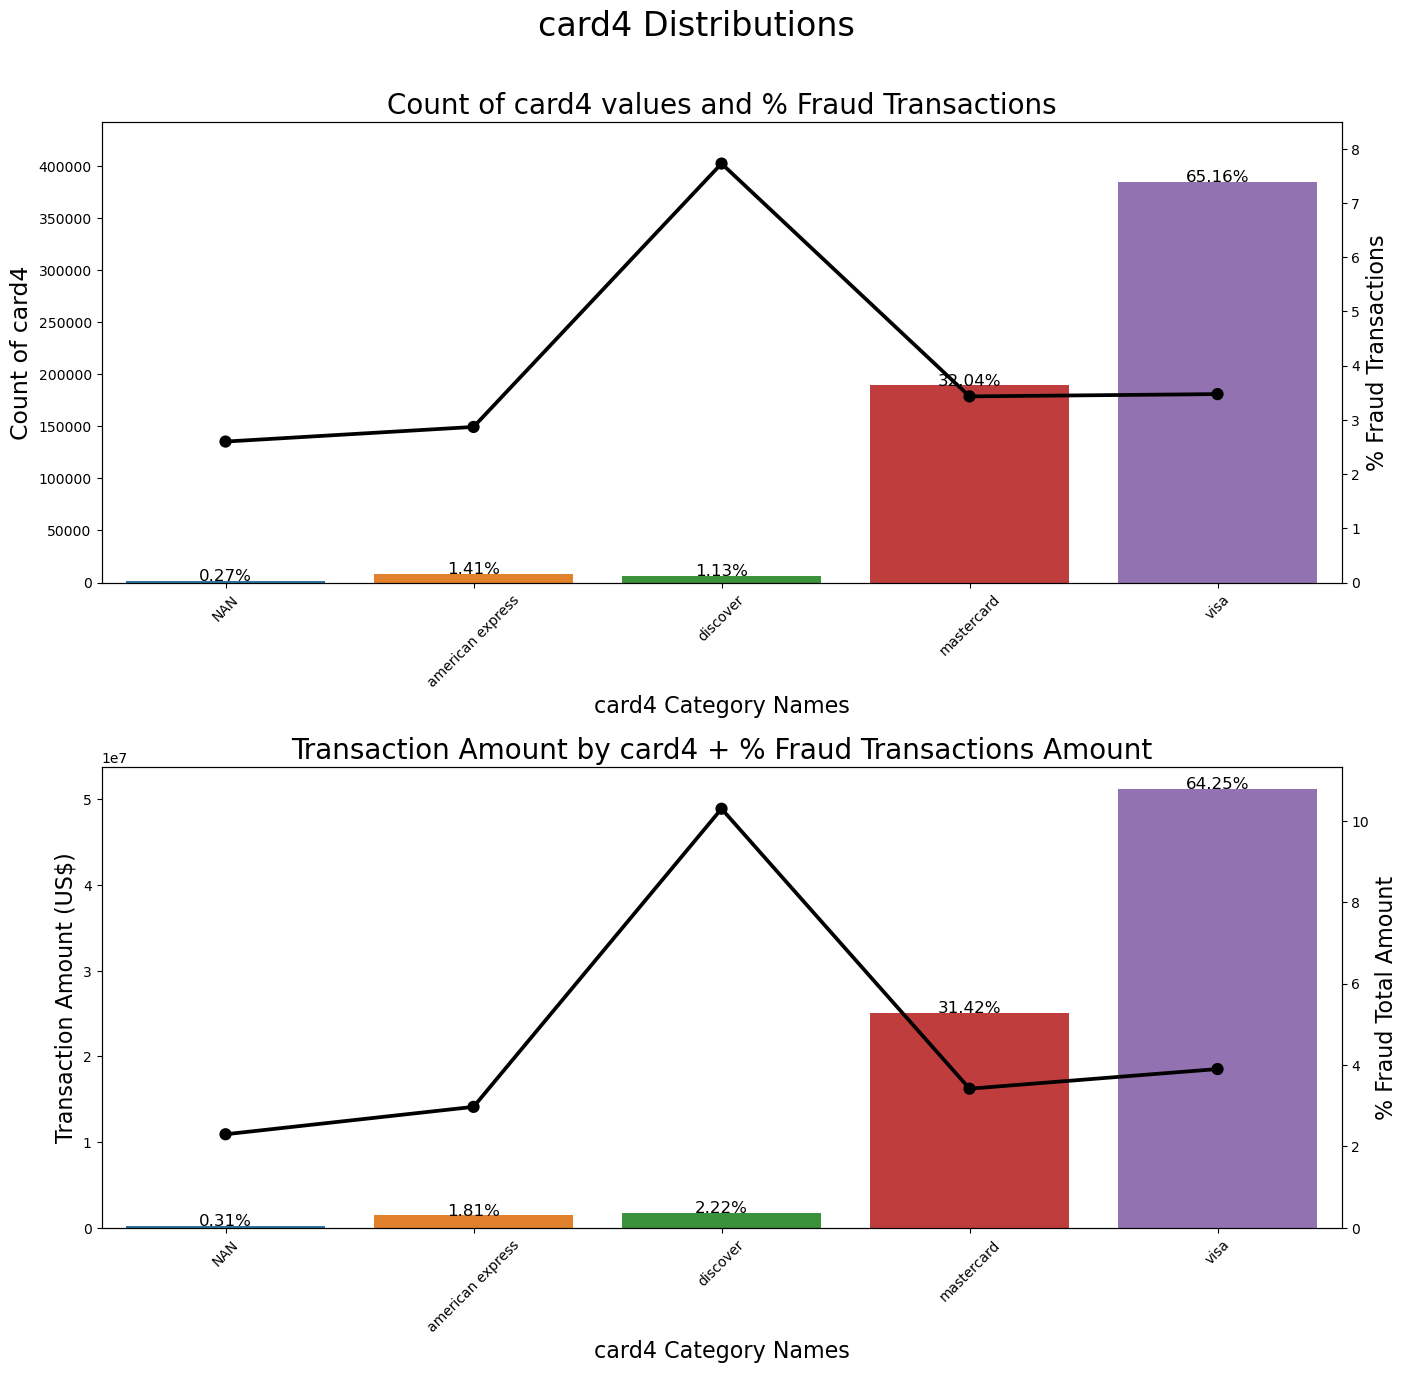

In [25]:
#| code-fold: true

ploting_cnt_amt(df_trans, 'card4')

In [26]:
#| code-fold: true

calculate_missing_percentage(df_trans, 'card6')
df_trans.card6 = df_trans.card6.fillna('NAN')

Missing value percentage for card6: 0.27%


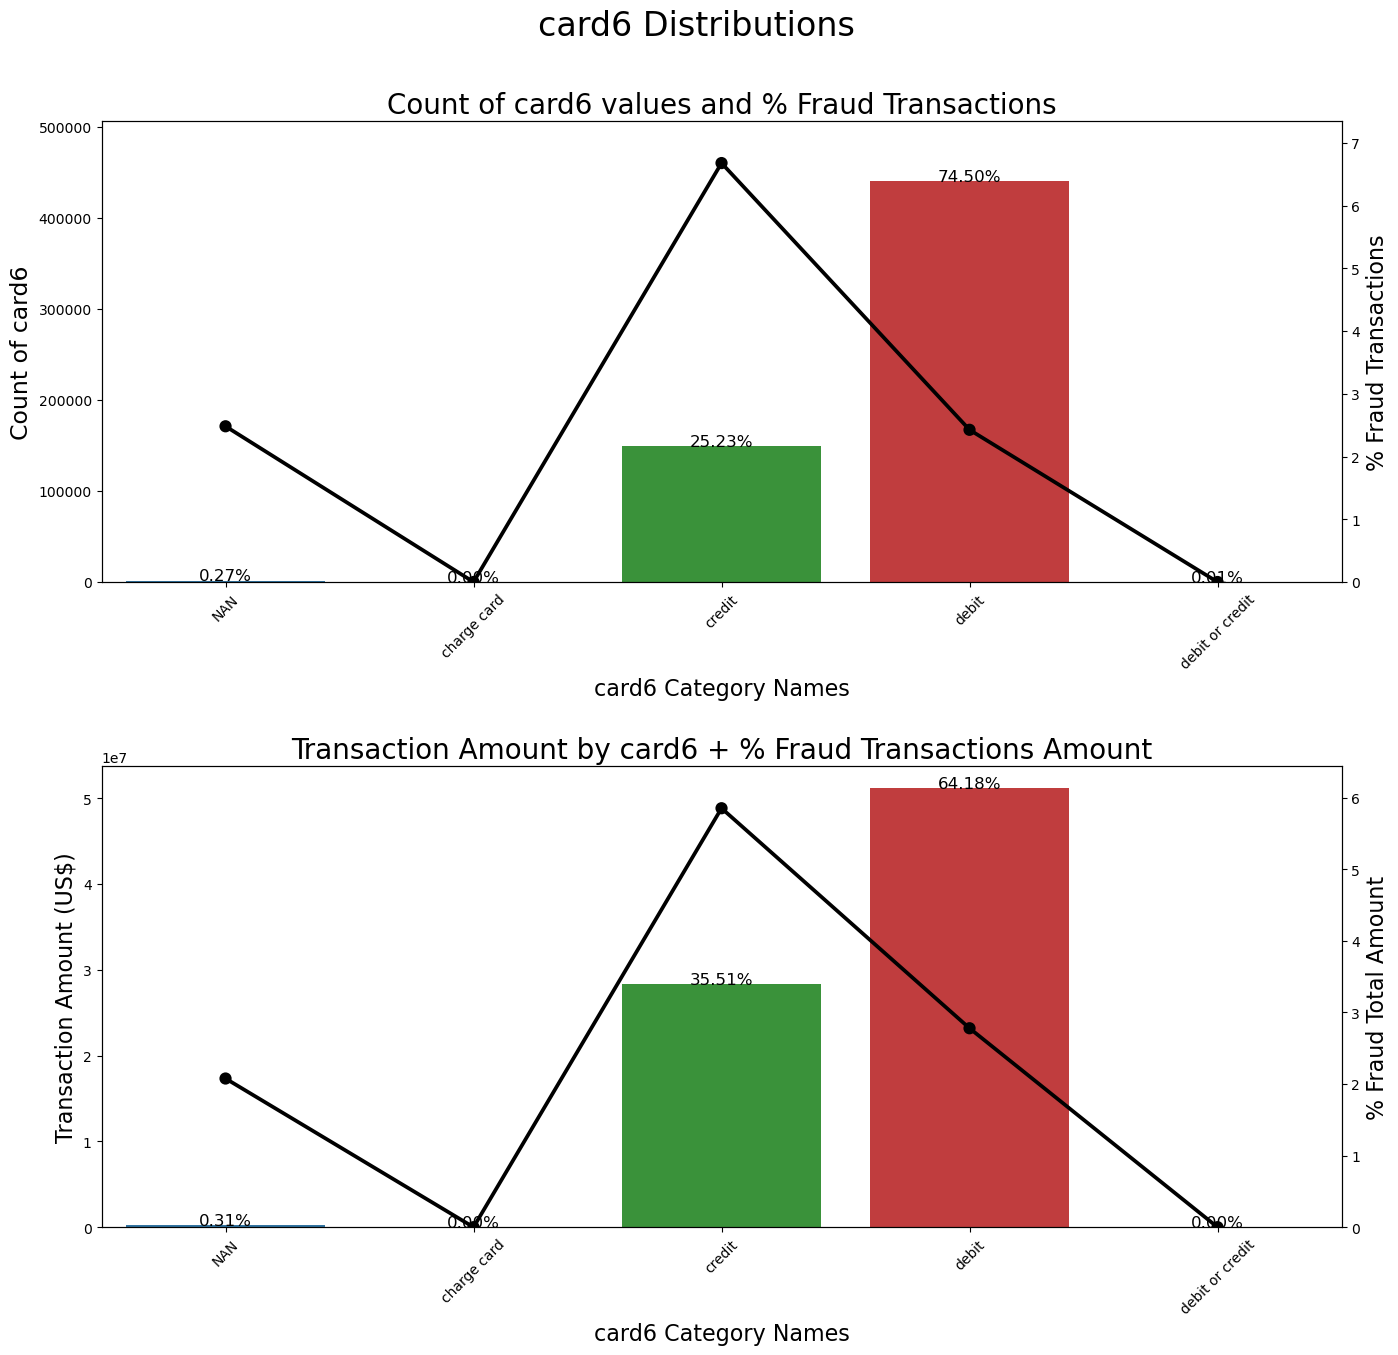

In [27]:
#| code-fold: true

ploting_cnt_amt(df_trans, 'card6')

### address

- addr1:
    1. Some addr1 have lower transaction and transaction amount but with higher fraud rate, which may imply addr1 is a factor of fraud rate.
    2. Missing values of addr1 have much higher fraud rate, which may be a good indicator for fraud.
    
- addr2:
    1. 99% is the same value, which indicates that it may not be a meaningful variable to predict fraud.

In [28]:
#| code-fold: true

resumetable(df_trans, ['addr1', 'addr2'])

Dataset Shape: (590540, 399)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value
0  addr1  float16    65706      332        315.0         325.0        330.0
1  addr2  float16    65706       74         87.0          87.0         87.0

addr1 and addr2 should be categorical, so let's transform them first. 

In [29]:
#| code-fold: true

df_trans['addr1'] = df_trans['addr1'].astype('object')
df_trans['addr2'] = df_trans['addr2'].astype('object')
resumetable(df_trans, ['addr1', 'addr2'])

Dataset Shape: (590540, 399)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  addr1  object    65706      332       315.0        325.0       330.0
1  addr2  object    65706       74        87.0         87.0        87.0

In [30]:
#| code-fold: true

calculate_missing_percentage(df_trans, 'addr1')
calculate_missing_percentage(df_trans, 'addr2')

Missing value percentage for addr1: 11.13%
Missing value percentage for addr2: 11.13%


Let's fill missing values with "NAN"

In [31]:
#| code-fold: true

df_trans.addr1 = df_trans.addr1.fillna('NAN')
df_trans.addr2 = df_trans.addr2.fillna('NAN')

In [32]:
#| code-fold: true

result = df_trans.groupby(['addr1'])['addr1'].count().sort_values(ascending=False)
total_count = result.sum()
result_percentage = (result / total_count) * 100
result_percentage

addr1
NAN      11.126427
299.0     7.846209
325.0     7.239306
204.0     7.115521
264.0     6.751448
           ...    
425.0     0.000169
227.0     0.000169
232.0     0.000169
417.0     0.000169
427.0     0.000169
Name: addr1, Length: 333, dtype: float64

There are 332 unique values, let's focus on addr1 that appears more than 1%

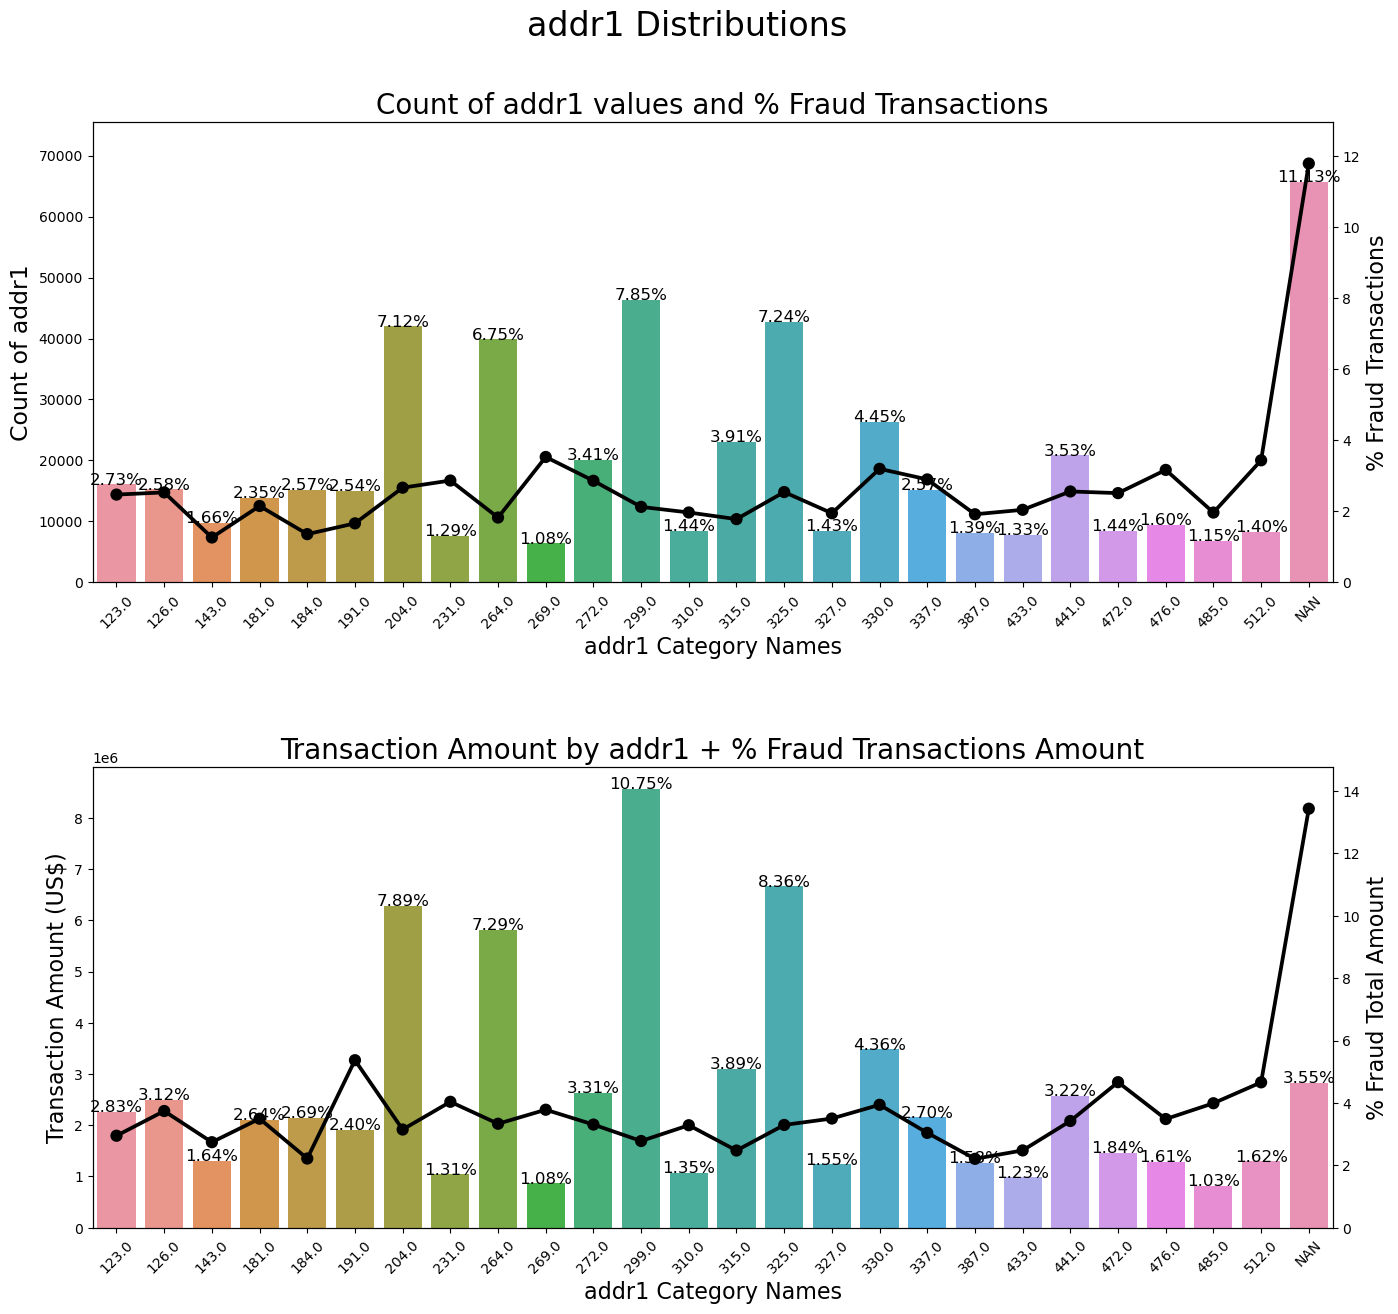

In [33]:
#| code-fold: true

indices = result_percentage[result_percentage > 1].index
selected_rows = df_trans.loc[df_trans.addr1.isin(indices)]
ploting_cnt_amt(selected_rows, 'addr1')

In [34]:
#| code-fold: true

result = df_trans.groupby(['addr2'])['addr2'].count().sort_values(ascending=False)
total_count = result.sum()
result_percentage = (result / total_count) * 100
result_percentage

addr2
87.0    88.136451
NAN     11.126427
60.0     0.522234
96.0     0.108037
32.0     0.015410
          ...    
22.0     0.000169
25.0     0.000169
50.0     0.000169
49.0     0.000169
55.0     0.000169
Name: addr2, Length: 75, dtype: float64

Almost all addr2 is 87, which indicates that this may not be a meaningful variable.

### P_Email domain

1. Most transactions come from Google, Yahoo and missing value.
2. While Microsoft has the 4th highest transaction, it has the 1st fraud rate.
3. While spectrum has relatively low fraud rate, it has the 1st percentage of fraud amount.
4. es has higher fraud rate and amount.

In [35]:
#| code-fold: true

resumetable(df_trans, ['P_emaildomain'])

Dataset Shape: (590540, 399)


Name  dtypes  Missing  Uniques First Value Second Value  \
0  P_emaildomain  object    94456       59         NaN    gmail.com   

   Third Value  
0  outlook.com

In [36]:
#| code-fold: true

calculate_missing_percentage(df_trans, 'P_emaildomain')
df_trans.P_emaildomain = df_trans.P_emaildomain.fillna('NAN')

Missing value percentage for P_emaildomain: 15.99%


Let's first rename similar domains to a same group of domain.

In [37]:
#| code-fold: true

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple', 'NAN':'NAN'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain']:
    df_trans[c + '_bin'] = df_trans[c].map(emails)
    
    df_trans[c + '_suffix'] = df_trans[c].map(lambda x: str(x).split('.')[-1])
    #If a suffix matches any of the values in the us_emails list, it's replaced with 'us' to indicate it's a U.S.-based domain. Otherwise, the original suffix remains.
    df_trans[c + '_suffix'] = df_trans[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

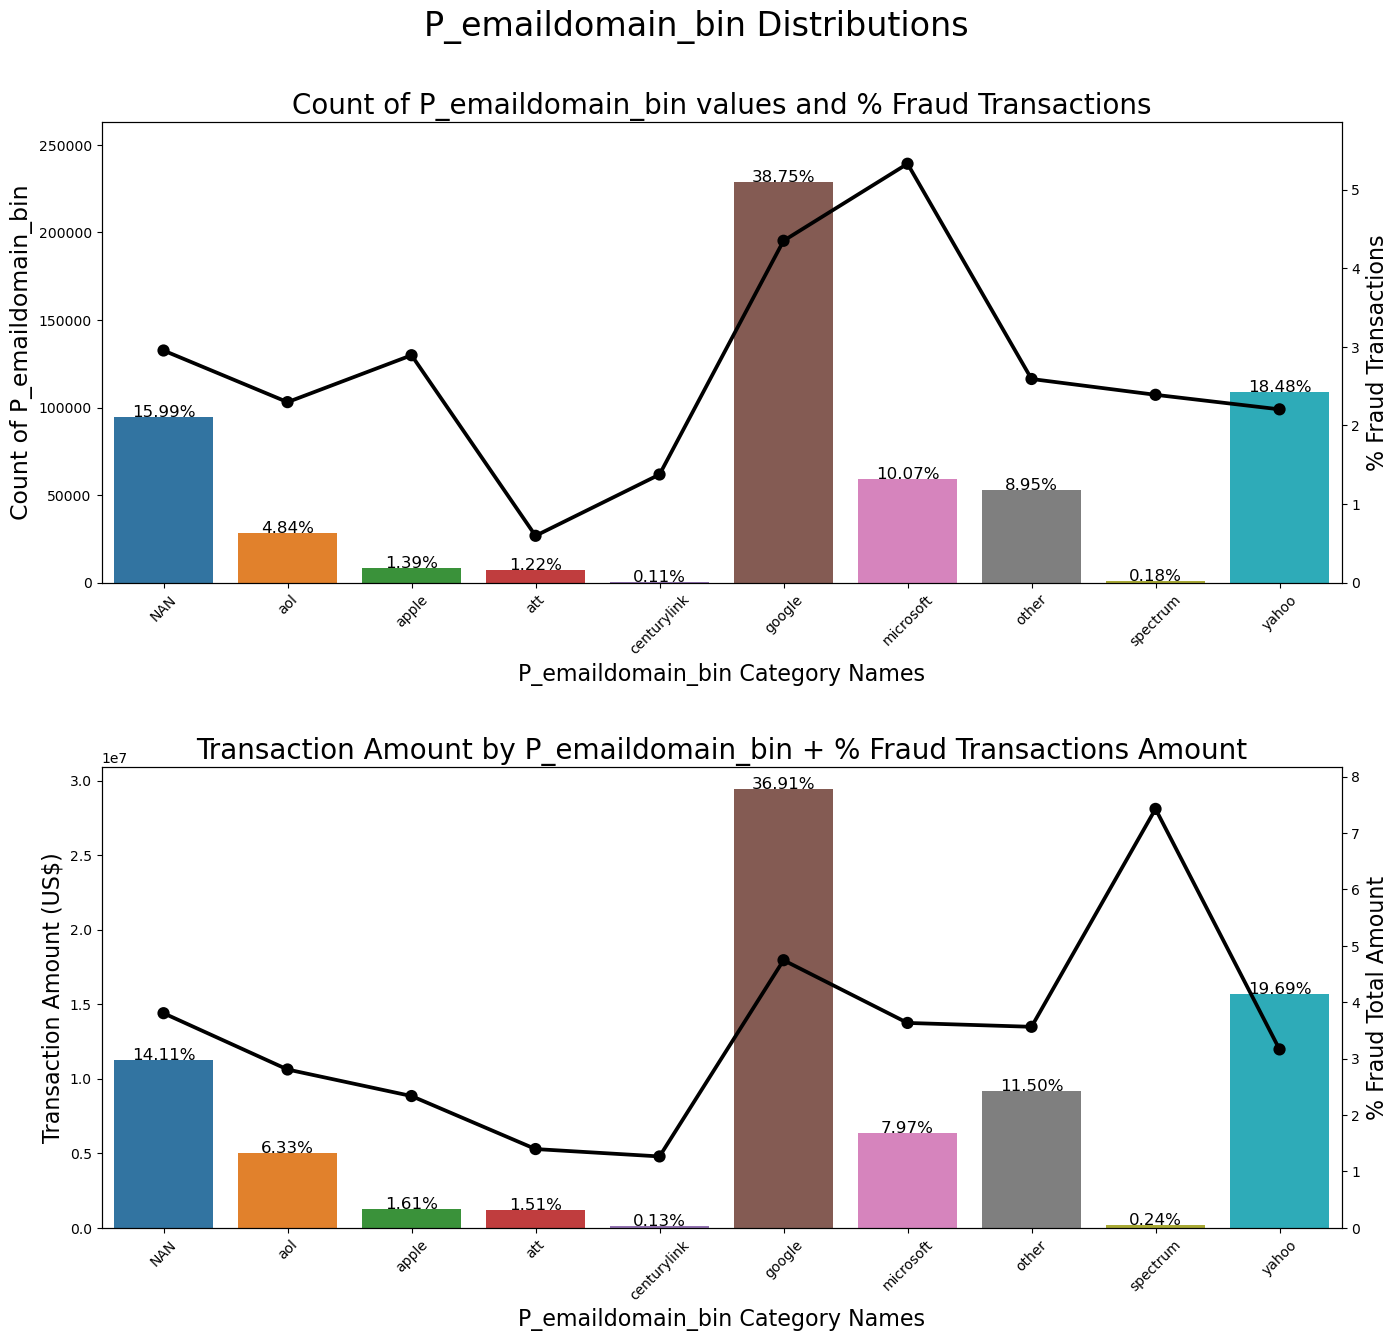

In [38]:
#| code-fold: true

ploting_cnt_amt(df_trans, 'P_emaildomain_bin')

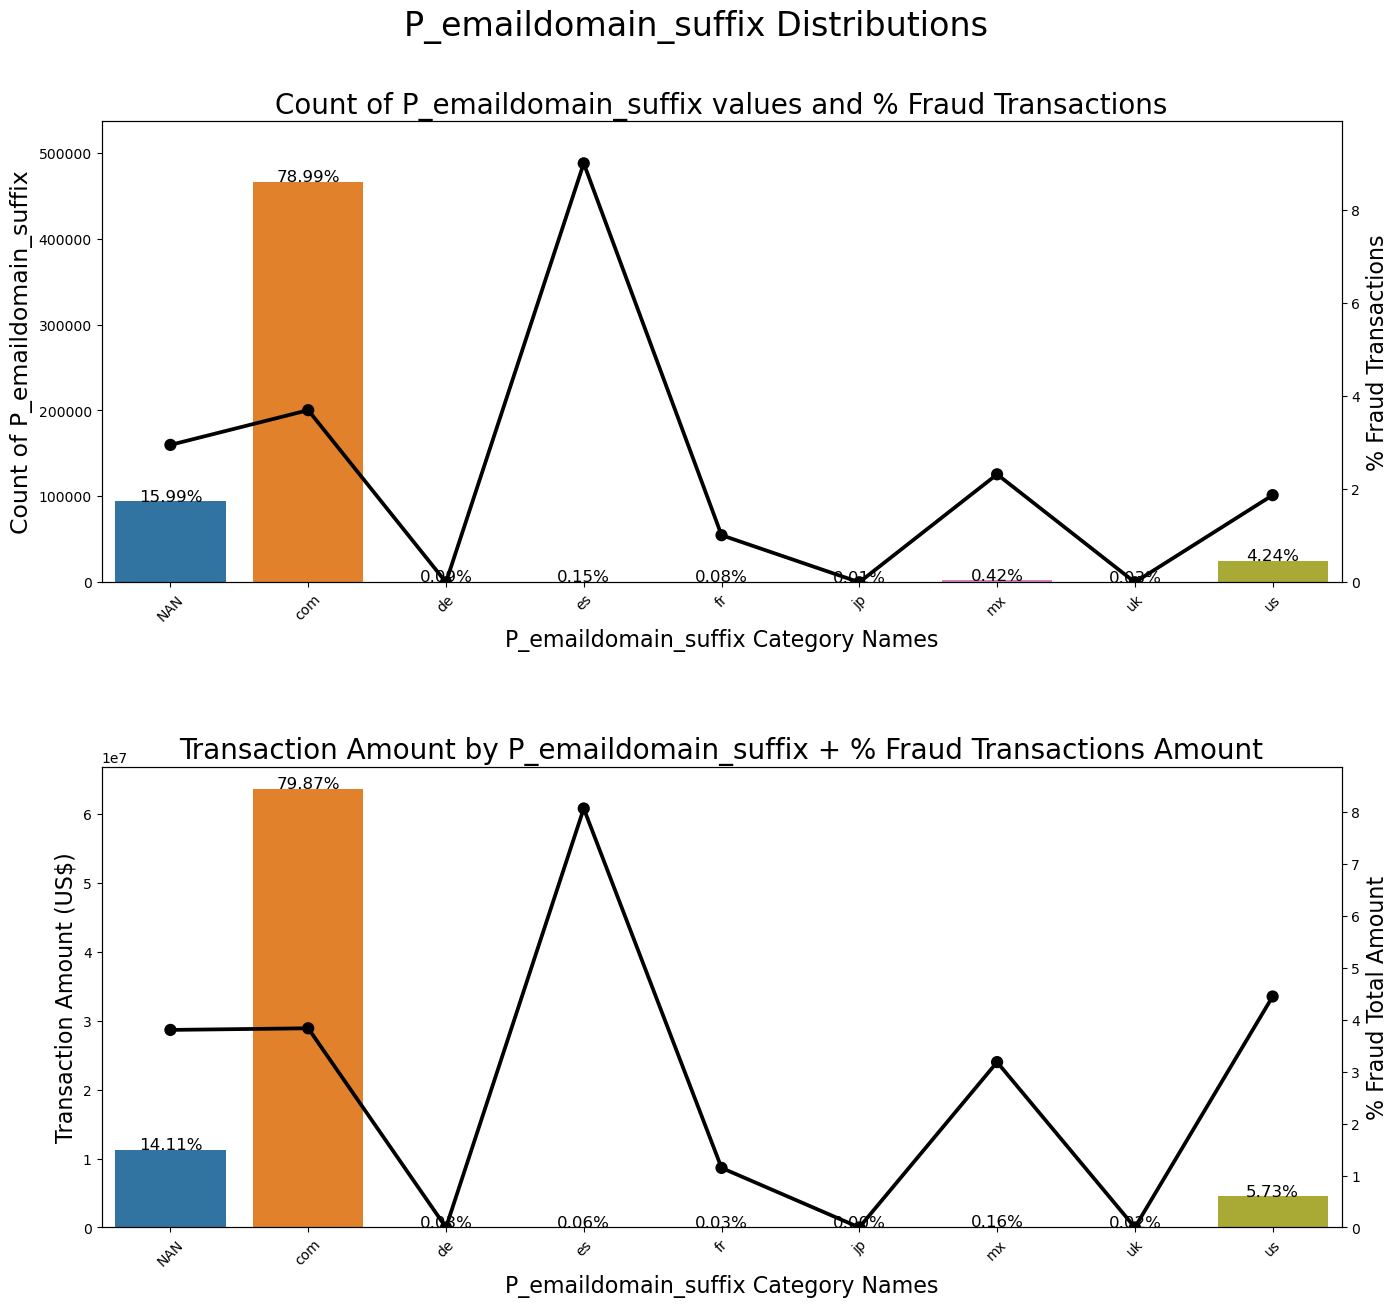

In [39]:
ploting_cnt_amt(df_trans, 'P_emaildomain_suffix')

### R_Email domain

1. Over 76% are missing value, so let's exlcude this column from further analysis.

In [40]:
#| code-fold: true

resumetable(df_trans, ['R_emaildomain'])

Dataset Shape: (590540, 401)


Name  dtypes  Missing  Uniques First Value Second Value  \
0  R_emaildomain  object   453249       60         NaN          NaN   

  Third Value  
0         NaN

In [41]:
#| code-fold: true

calculate_missing_percentage(df_trans, 'R_emaildomain')

Missing value percentage for R_emaildomain: 76.75%


### C1-C14, D1-D9, M1-M9, Vxxx

Given that these features are masked and their meanings are not discernible from their values, to prioritize providing more interpretable insights, let's exclude them from the subsequent analysis.

## 6-2. EDA-id

In [42]:
#| code-fold: true

resumetable(df_id, df_id.columns.tolist())

Dataset Shape: (144233, 41)


Name   dtypes  Missing  Uniques                    First Value  \
0   TransactionID    int32        0   144233                        2987004   
1           id_01  float16        0       77                            0.0   
2           id_02  float32     3361   115655                        70787.0   
3           id_03  float16    77909       24                            NaN   
4           id_04  float16    77909       15                            NaN   
5           id_05  float16     7368       93                            NaN   
6           id_06  float16     7368      101                            NaN   
7           id_07  float16   139078       84                            NaN   
8           id_08  float16   139078       94                            NaN   
9           id_09  float16    69307       46                            NaN   
10          id_10  float16    69307       62                            NaN   
11          id_11  float16     3255      146                          100.0   
12          id_12   object        0        2                       NotFound   
13          id_13  float16    16913       54                            NaN   
14          id_14  float16    64189       25                         -480.0   
15          id_15   object     3248        3                            New   
16          id_16   object    14893        2                       NotFound   
17          id_17  float16     4864      104                          166.0   
18          id_18  float16    99120       18                            NaN   
19          id_19  float16     4915      522                          542.0   
20          id_20  float16     4972      394                          144.0   
21          id_21  float16   139074      490                            NaN   
22          id_22  float16   139064       25                            NaN   
23          id_23   object   139064        3                            NaN   
24          id_24  float16   139486       12                            NaN   
25          id_25  float16   139101      341                            NaN   
26          id_26  float16   139070       95                            NaN   
27          id_27   object   139064        2                            NaN   
28          id_28   object     3255        2                            New   
29          id_29   object     3255        2                       NotFound   
30          id_30   object    66668       75                    Android 7.0   
31          id_31   object     3951      130            samsung browser 6.2   
32          id_32  float16    66647        4                           32.0   
33          id_33   object    70944      260                      2220x1080   
34          id_34   object    66428        4                 match_status:2   
35          id_35   object     3248        2                              T   
36          id_36   object     3248        2                              F   
37          id_37   object     3248        2                              T   
38          id_38   object     3248        2                              T   
39     DeviceType   object     3423        2                         mobile   
40     DeviceInfo   object    25567     1786  SAMSUNG SM-G892A Build/NRD90M   

          Second Value  Third Value  
0              2987008      2987010  
1                 -5.0         -5.0  
2              98945.0     191631.0  
3                  NaN          0.0  
4                  NaN          0.0  
5                  0.0          0.0  
6                 -5.0          0.0  
7                  NaN          NaN  
8                  NaN          NaN  
9                  NaN          0.0  
10                 NaN          0.0  
11               100.0        100.0  
12            NotFound     NotFound  
13                49.0         52.0  
14              -300.0          NaN  
15                 New        Found  
16            NotFound        Found  
17        

From the table above, we can select some potentially useful variables including id_30, id_31, DeviceType, DeviceInfo.

In [93]:
#| code-fold: true

# merge two df for better analysis
df_merged = df_trans.merge(df_id, on='TransactionID', how='left')

### id_30

1. This column likely represents operation system.
2. More than 86% are missing values, so we’ll exclude this variable in the following analysis.

In [44]:
#| code-fold: true

resumetable(df_merged, ['id_30'])

Dataset Shape: (590540, 441)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  id_30  object   512975       75         NaN          NaN         NaN

In [45]:
#| code-fold: true

calculate_missing_percentage(df_merged, 'id_30')

Missing value percentage for id_30: 86.87%


### id_31

1. This column likely represents browser type.
2. More than 70% are missing values, so we'll exclude this variable in the following analysis.

In [46]:
#| code-fold: true

resumetable(df_merged, ['id_31'])

Dataset Shape: (590540, 441)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  id_31  object   450258      130         NaN          NaN         NaN

In [47]:
#| code-fold: true

calculate_missing_percentage(df_merged, 'id_31')

Missing value percentage for id_31: 76.25%


### DeviceType

1. This column contains only two possibilites: desktop and mobile.
2. More than 70% are missing values, so we’ll exclude this variable in the following analysis.

In [48]:
#| code-fold: true

resumetable(df_merged, ['DeviceType'])

Dataset Shape: (590540, 441)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  DeviceType  object   449730        2         NaN          NaN         NaN

In [49]:
#| code-fold: true

calculate_missing_percentage(df_merged, 'DeviceType')

Missing value percentage for DeviceType: 76.16%


In [50]:
#| code-fold: true

df_merged.DeviceType.value_counts()

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64

### DeviceInfo

1. This column also have around 80% missing values, so we'll also exclude it.

In [51]:
#| code-fold: true

resumetable(df_merged, ['DeviceInfo'])
calculate_missing_percentage(df_merged, 'DeviceInfo')
df_merged.DeviceInfo.value_counts()

Dataset Shape: (590540, 441)
Missing value percentage for DeviceInfo: 79.91%


Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
LGMS345            1
verykool           1
XT1072             1
LG-H931            1
0PJA2              1
Name: DeviceInfo, Length: 1786, dtype: int64

## 6-3. EDA Summary

After reviewing all columns, the following ones are selected for their meaningful content and will be used:

- Date
- _Weekdays
- _Hours
- _Days
- TransactionAmt
- Log_TransactionAmt
- ProductCD
- card4
- card6
- addr1
- P_emaildomain_bin
- P_emaildomain_suffix

# 7. Modeling

## 7-1. Select useful columns

In [52]:
#| code-fold: true
selected_columns = [
    'isFraud','Date', '_Weekdays', '_Hours', '_Days',
    'TransactionAmt', 'Log_TransactionAmt', 'ProductCD', 'card4', 'card6',
    'addr1', 'P_emaildomain_bin', 'P_emaildomain_suffix'
]

# Selecting the specified columns
df_train = df_merged[selected_columns]

In [53]:
#| code-fold: true
resumetable(df_train, df_train.columns.tolist())

Dataset Shape: (590540, 13)


Name          dtypes  Missing  Uniques  \
0                isFraud            int8        0        2   
1                   Date  datetime64[ns]        0   573349   
2              _Weekdays           int64        0        7   
3                 _Hours           int64        0       24   
4                  _Days           int64        0       31   
5         TransactionAmt         float64        0     8195   
6     Log_TransactionAmt         float64        0     8195   
7              ProductCD          object        0        5   
8                  card4          object        0        5   
9                  card6          object        0        5   
10                 addr1          object        0      333   
11     P_emaildomain_bin          object        0       10   
12  P_emaildomain_suffix          object        0        9   

            First Value         Second Value          Third Value  
0                     0                    0                    0  
1   2017-12-02 00:00:00  2017-12-02 00:00:01  2017-12-02 00:01:09  
2                     5                    5                    5  
3                     0                    0                    0  
4                     2                    2                    2  
5                  68.5                 29.0                 59.0  
6              4.241327             3.401197             4.094345  
7                     W                    W                    W  
8              discover           mastercard                 visa  
9                credit               credit                debit  
10                315.0                325.0                330.0  
11                  NAN               google            microsoft  
12                  NAN                  com                  com

## 7-2. Logistic Regression

Let's start with a logistic regression as our base line model.

1. Change data type from int to object
    - _Weekdays
    - _Hours
    - _Days

2. Group low frequency values of addr1:
    - Avoid overfitting and curse of dimensionality

3. Set Date to index and sort ascending:
    - for time series data, it's better to split by time to make sure training data is older than test data, which is different from normal train test split.

4. One hot encoding:
    - _Weekdays
    - _Hours
    - _Days
    - ProductCD
    - card4
    - card6
    - addr1
    - P_emaildomain_bin
    - P_emaildomain_suffix

5. Standerdization:
    - TransactionAmt
    

6. Split data

7. How to deal with imbalance dataset? (oversampling techinque discussion):
    - Recall that in EDA of isFraud variable that fraud transactions occur far less frequently compared to non-fraudulent ones. To address this class imbalance, performing oversampling specifically on fraud transactions becomes crucial, allowing us to better capture and train the model on these rare instances.

8. Overfitting:
    - Using regularization can avoid overfitting problem, but regularization performed on logistic regression with this dataset is not very prominant. We'll further explore other models that may solve this problem.

9. Conclusion:
    - The best model's precision-recall auc is 0.37, which can can capture 63 % of fraud transactions and the prediction precision is 9 %. 24 % of non-fraud transactions are misclassified

1.change data type from int to object

In [54]:
#| code-fold: true
# 1. change data type from int to object
df_train[['_Weekdays', '_Hours', '_Days']] = df_train[['_Weekdays', '_Hours', '_Days']].astype('object')
resumetable(df_train, ['_Weekdays', '_Hours', '_Days'])

Dataset Shape: (590540, 13)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  _Weekdays  object        0        7           5            5           5
1     _Hours  object        0       24           0            0           0
2      _Days  object        0       31           2            2           2

2.Group low frequency values of `addr1`

In [55]:
#| code-fold: true
# 2. Group low frequency (<1%)values of addr1
result = df_train.groupby('addr1').size().sort_values(ascending=False)
total_count = result.sum()
result_percentage = (result / total_count) * 100
# Identify values with percentages less than 1
values_to_group = result_percentage[result_percentage < 1].index.tolist()
# Replace those values in the DataFrame with the new category 'others'
df_train['addr1'] = df_train['addr1'].apply(lambda x: 'others' if x in values_to_group else x)
print('reduce unique values of addr1 from 333 to 27')
resumetable(df_train, ['addr1'])

reduce unique values of addr1 from 333 to 27
Dataset Shape: (590540, 13)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  addr1  object        0       27       315.0        325.0       330.0

3.set `Date` to index and sort ascending

In [56]:
#| code-fold: true
# 3.set Date to index and sort ascending
df_train.set_index('Date', inplace=True)
df_train.sort_index(ascending=True, inplace=True)

4.One hot encoding

In [57]:
#| code-fold: true
# 4.One hot encoding
# Splitting into features and target variable
X = df_train.drop('isFraud', axis=1)
y = df_train['isFraud']

# List of categorical columns for one hot encoding
columns_to_encode = ['_Weekdays', '_Hours', '_Days', 'ProductCD', 'card4', 'card6','addr1', 'P_emaildomain_bin', 'P_emaildomain_suffix']
X_transformed = pd.get_dummies(X, columns=columns_to_encode, prefix=columns_to_encode)

5.Standerdization

In [58]:
#| code-fold: true
#5. Standerdization:
columns_to_standerdize = ['TransactionAmt']
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the scaler on your numeric data
X_scaled = scaler.fit_transform(X[columns_to_standerdize])
# replcae with original TransactionAmt
X_transformed['TransactionAmt'] = X_scaled

In [59]:
X_transformed.head(3)

TransactionAmt  Log_TransactionAmt  _Weekdays_0  \
Date                                                                   
2017-12-02 00:00:00       -0.278174            4.241327            0   
2017-12-02 00:00:01       -0.443337            3.401197            0   
2017-12-02 00:01:09       -0.317897            4.094345            0   

                     _Weekdays_1  _Weekdays_2  _Weekdays_3  _Weekdays_4  \
Date                                                                      
2017-12-02 00:00:00            0            0            0            0   
2017-12-02 00:00:01            0            0            0            0   
2017-12-02 00:01:09            0            0            0            0   

                     _Weekdays_5  _Weekdays_6  _Hours_0  ...  \
Date                                                     ...   
2017-12-02 00:00:00            1            0         1  ...   
2017-12-02 00:00:01            1            0         1  ...   
2017-12-02 00:01:09            1            0         1  ...   

                     P_emaildomain_bin_yahoo  P_emaildomain_suffix_NAN  \
Date                                                                     
2017-12-02 00:00:00                        0                         1   
2017-12-02 00:00:01                        0                         0   
2017-12-02 00:01:09                        0                         0   

                     P_emaildomain_suffix_com  P_emaildomain_suffix_de  \
Date                                                                     
2017-12-02 00:00:00                         0                        0   
2017-12-02 00:00:01                         1                        0   
2017-12-02 00:01:09                         1                        0   

                     P_emaildomain_suffix_es  P_emaildomain_suffix_fr  \
Date                                                                    
2017-12-02 00:00:00                        0                        0   
2017-12-02 00:00:01                        0                        0   
2017-12-02 00:01:09                        0                        0   

                     P_emaildomain_suffix_jp  P_emaildomain_suffix_mx  \
Date                                                                    
2017-12-02 00:00:00                        0                        0   
2017-12-02 00:00:01                        0                        0   
2017-12-02 00:01:09                        0                        0   

                     P_emaildomain_suffix_uk  P_emaildomain_suffix_us  
Date                                                                   
2017-12-02 00:00:00                        0                        0  
2017-12-02 00:00:01                        0                        0  
2017-12-02 00:01:09                        0                        0  

[3 rows x 125 columns]

6.Split data

In [60]:
#| code-fold: true
#6. Split data
# Check the range of dates
min_date = X_transformed.index.min()
max_date = X_transformed.index.max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2017-12-02 00:00:00
Maximum date: 2018-06-01 23:58:51


The date range spans approximately 6 months. Given that it's a time series dataset, it's more appropriate to partition it based on dates rather than employing the conventional train-test split.
Let's use the first 5 months as training data and the last month as testing data.

In [61]:
train_date = '2018-04-30'
test_date = '2018-05-01'
x_train, y_train = X_transformed.loc[:train_date], y.loc[:train_date]
x_test, y_test = X_transformed.loc[test_date:], y.loc[test_date:]

7.How to deal with imbalance dataset? (oversampling techinque discussion)

Recall that in our EDA "isFraud" section, it was observed that only 3.5% of records were labeled as 'fraud.' This class imbalance poses a challenge for model performance, as the model may struggle to capture the characteristics of fraudulent records effectively. Consequently, employing oversampling techniques becomes crucial to augment the number of fraud transactions, enhancing the model's ability for more effective modeling.

Let's start by building the model without oversampling.

In [62]:
#| code-fold: true
# 8. Perform logistic regression
logreg = LogisticRegression(random_state=42)

# Train the model using the training data
logreg.fit(x_train, y_train)

# Predict on the train data
x_train_pred = logreg.predict(x_train)
# Predict on the test data
y_pred = logreg.predict(x_test)


(Without Oversampling): Show performance on training data...
F1 Score: 0.005022257733135487
Confusion Matrix:
[[480635     28]
 [ 17406     44]]
Precision is 61 %; Recall is 0 %
PR-RC AUC: 0.32428823963938536


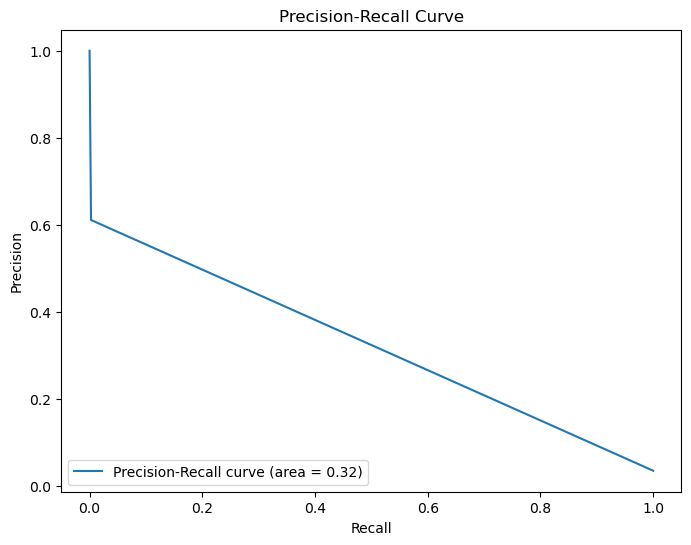

Can capture 0 % of fraud transactions and the prediction precision is 61 %. 0 % of non-fraud transactions are misclassified


In [63]:
#| code-fold: true
#show performance
print("(Without Oversampling): Show performance on training data...")
evaluate_results(y_train, x_train_pred)

(Without Oversampling): Show performance on testing data...
F1 Score: 0.0037243947858473002
Confusion Matrix:
[[89211     3]
 [ 3207     6]]
Precision is 67 %; Recall is 0 %
PR-RC AUC: 0.35161586679095885


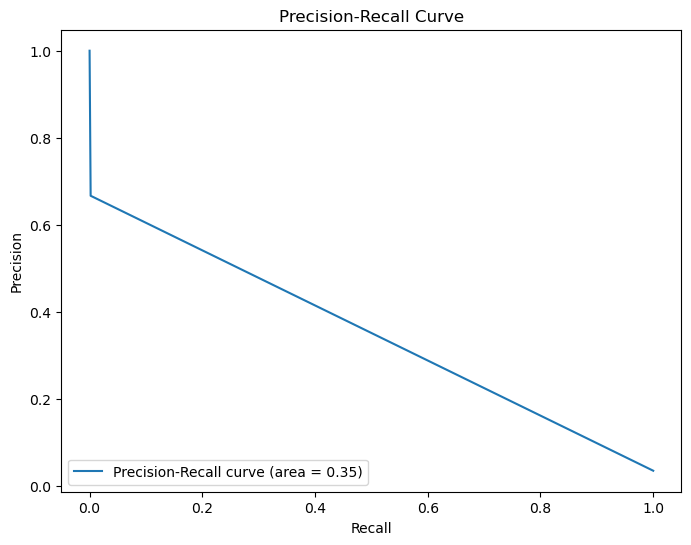

Can capture 0 % of fraud transactions and the prediction precision is 67 %. 0 % of non-fraud transactions are misclassified


In [64]:
#| code-fold: true
#show performance
print("(Without Oversampling): Show performance on testing data...")
evaluate_results(y_test, y_pred)

Without oversampling PR-RC-AUC: 
- Training data: 0.32
- Testing data: 0.35

Now let's perform oversampling and observe the changes.

In [65]:
#| code-fold: true
#7. Perform oversampling to solve imbalance problem
# https://www.kaggle.com/code/shahules/tackling-class-imbalance
X=pd.concat([x_train,y_train],axis=1)


not_fraud=X[X.isFraud==0]
fraud=X[X.isFraud==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# replace original x_train, y_train
x_train = upsampled.drop('isFraud', axis=1)
y_train = upsampled['isFraud']

# check new class counts
print("check new class counts")
upsampled.isFraud.value_counts()


check new class counts


0    480663
1    480663
Name: isFraud, dtype: int64

In [66]:
#| code-fold: true
# 8. Perform logistic regression
logreg = LogisticRegression(random_state=42)

# Train the model using the training data
logreg.fit(x_train, y_train)

# Predict on the train data
x_train_pred = logreg.predict(x_train)
# Predict on the test data
y_pred = logreg.predict(x_test)


(With Oversampling): Show performance on training data...
F1 Score: 0.6837879685114658
Confusion Matrix:
[[355648 125015]
 [166006 314657]]
Precision is 72 %; Recall is 65 %
PR-RC AUC: 0.7714893216881513


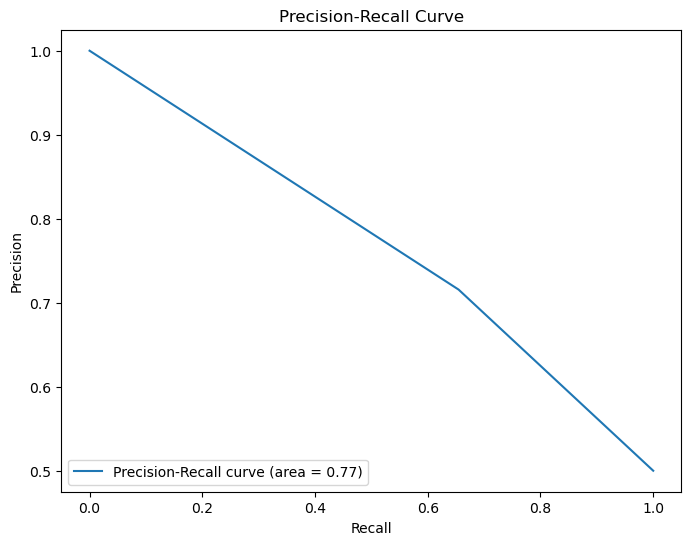

Can capture 65 % of fraud transactions and the prediction precision is 72 %. 26 % of non-fraud transactions are misclassified


In [67]:
#| code-fold: true
#show performance
print("(With Oversampling): Show performance on training data...")
evaluate_results(y_train, x_train_pred)

(With Oversampling): Show performance on testing data...
F1 Score: 0.15101787215379556
Confusion Matrix:
[[67132 22082]
 [ 1147  2066]]
Precision is 9 %; Recall is 64 %
PR-RC AUC: 0.37048914697029617


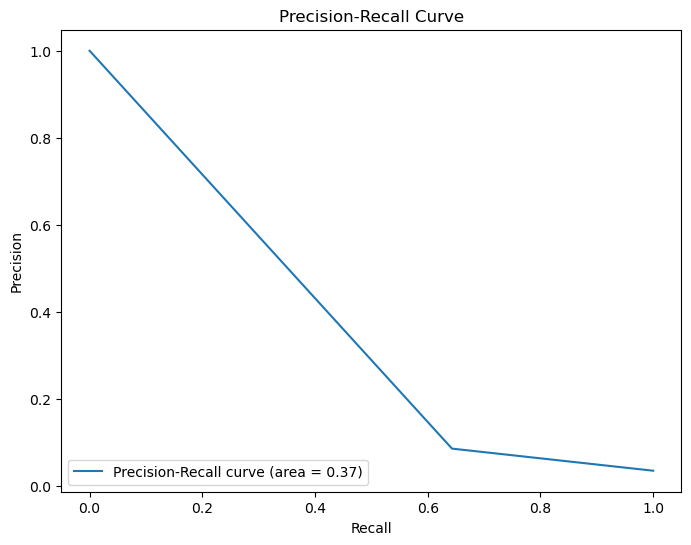

Can capture 64 % of fraud transactions and the prediction precision is 9 %. 25 % of non-fraud transactions are misclassified


In [68]:
#| code-fold: true
#show performance
print("(With Oversampling): Show performance on testing data...")
evaluate_results(y_test, y_pred)

With oversampling PR-RC-AUC: 
- Training data: 0.77
- Testing data: 0.37

With oversampling, training data's PR-RC-AUC increases from 0.32 to 0.77 and testing data's PR-RC-AUC increases from 0.35 to 0.37. This shows the oversampling technique help the model to better capture characteristics of fraudulent transactions.

8. Solve overfitting

The Precision-Recall Area Under the Curve (PR-RC-AUC) for the testing data is lower at 0.37 compared to the training data's higher PR-RC-AUC of 0.77. This discrepancy suggests the presence of an overfitting problem. To address this issue, let's implement some regularization techniques.

In [69]:
#Standardization is often recommended when using regularization.
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [70]:
#| code-fold: true
# 8. Perform logistic regression
logreg = LogisticRegression(random_state=42, C=0.00001)

# Train the model using the training data
logreg.fit(x_train_scaled, y_train)

# Predict on the train data
x_train_pred = logreg.predict(x_train_scaled)
# Predict on the test data
y_pred = logreg.predict(x_test_scaled)


F1 Score: 0.6758616444559736
Confusion Matrix:
[[358994 121669]
 [173223 307440]]
Precision is 72 %; Recall is 64 %
PR-RC AUC: 0.768134791760063


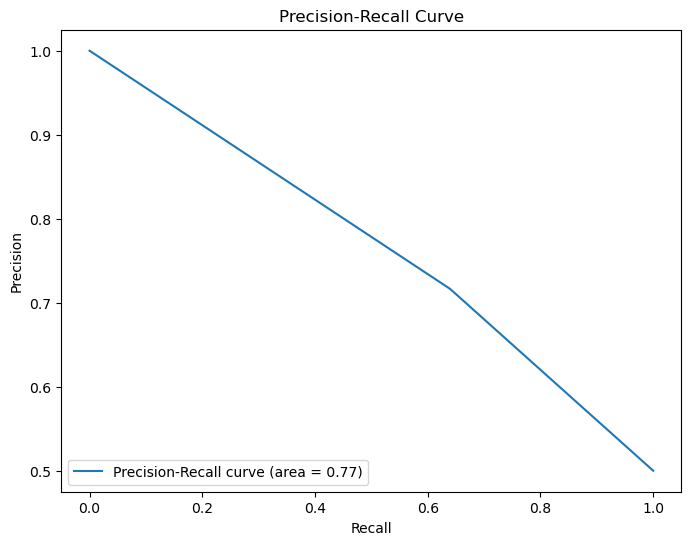

Can capture 64 % of fraud transactions and the prediction precision is 72 %. 25 % of non-fraud transactions are misclassified


In [71]:
#| code-fold: true
#show performance
evaluate_results(y_train, x_train_pred)

F1 Score: 0.1540732889158086
Confusion Matrix:
[[68046 21168]
 [ 1178  2035]]
Precision is 9 %; Recall is 63 %
PR-RC AUC: 0.3669069132910227


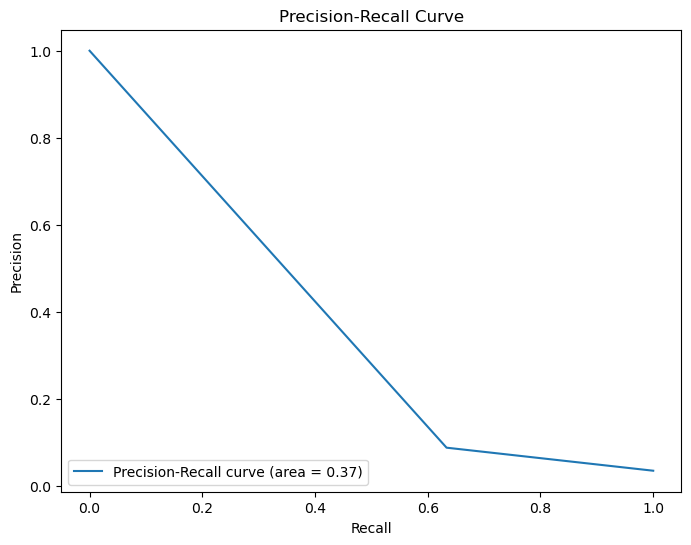

Can capture 63 % of fraud transactions and the prediction precision is 9 %. 24 % of non-fraud transactions are misclassified


In [72]:
#| code-fold: true
#show performance
evaluate_results(y_test, y_pred)

Regularization performed on logistic regression is not very prominant. Let's further explore other models that may solve this problem.

## 7-3. Decision Tree

1. Change data type from int to object
    - _Weekdays
    - _Hours
    - _Days

2. Group low frequency values of addr1:
    - Avoid overfitting and curse of dimensionality

3. Set Date to index and sort ascending:
    - for time series data, it's better to split by time to make sure training data is older than test data, which is different from normal train test split.

4. One hot encoding: Decision Tree is able to handle both numerical and categorical data. However, the scikit-learn implementation does not support categorical variables for now. 
    - _Weekdays
    - _Hours
    - _Days
    - ProductCD
    - card4
    - card6
    - addr1
    - P_emaildomain_bin
    - P_emaildomain_suffix

5. Standerdization:
    - TransactionAmt
    

6. Split data

7. Perform oversampling to solve imbalance problem:
    - Recall that in EDA of isFraud variable that fraud transactions occur far less frequently compared to non-fraudulent ones. To address this class imbalance, performing oversampling specifically on fraud transactions becomes crucial, allowing us to better capture and train the model on these rare instances.

8. Perform deicision tree

9. Evaluate Results:
    - Confusion Matrix
    - F1-score
    - Recall-Precision curve AUC

10. Conclusion:
    - The best model's precision-recall auc is 0.36, which can capture 62 % of fraud transactions and the prediction precision is 8 %. 26 % of non-fraud transactions are misclassified

In [73]:
#| code-fold: true
# Selecting the specified columns
df_train = df_merged[selected_columns]
# 1. change data type from int to object
df_train[['_Weekdays', '_Hours', '_Days']] = df_train[['_Weekdays', '_Hours', '_Days']].astype('object')

# 2. Group low frequency values of addr1
df_train = group_low_percentage_values(df_train, 'addr1', threshold=1)

# 3. Set Date to index and sort ascending
df_train.set_index('Date', inplace=True)
df_train.sort_index(ascending=True, inplace=True)

# Splitting into features and target variable
X = df_train.drop('isFraud', axis=1)
y = df_train['isFraud']

# 4. One hot encoding
columns_to_encode = ['_Weekdays', '_Hours', '_Days', 'ProductCD', 'card4', 'card6','addr1', 'P_emaildomain_bin', 'P_emaildomain_suffix']
X_transformed = pd.get_dummies(X, columns=columns_to_encode, prefix=columns_to_encode)

# 5. Standerdization
columns_to_standerdize = ['TransactionAmt']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[columns_to_standerdize])
X_transformed['TransactionAmt'] = X_scaled

# 6. Split data
train_date = '2018-04-30'
test_date = '2018-05-01'
x_train, y_train, x_test, y_test = split_data_by_date(X_transformed, y, train_date, test_date)

# 7. oversampling
X=pd.concat([x_train,y_train],axis=1)
upsampled_data = upsample_minority_class(X)
x_train = upsampled.drop('isFraud', axis=1)
y_train = upsampled['isFraud']

In [74]:
#| code-fold: true
#8. Decision Tree

# 1% of total values
threshold = round(x_train.shape[0]*0.001)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=20, min_samples_split=threshold, min_samples_leaf = threshold, random_state=42)

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

# Predict on the train data
x_train_pred = clf.predict(x_train)
# Predict on the test data
y_pred = clf.predict(x_test)

F1 Score: 0.7293538142181031
Confusion Matrix:
[[368797 111866]
 [140550 340113]]
Precision is 75 %; Recall is 71 %
PR-RC AUC: 0.8031465226186614


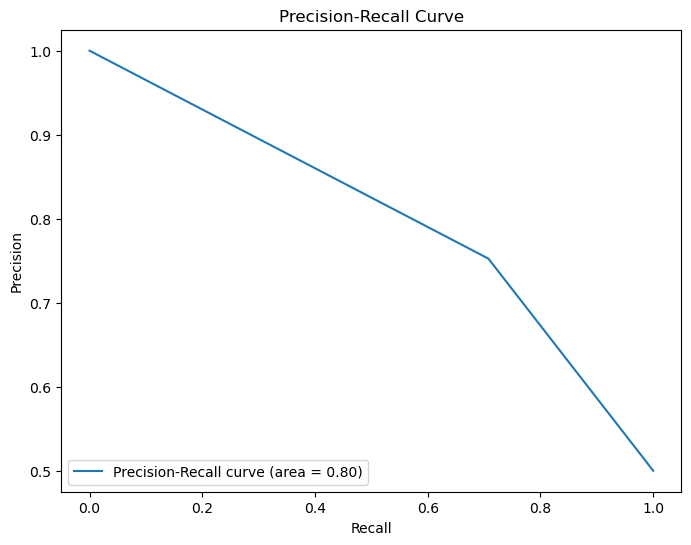

Can capture 71 % of fraud transactions and the prediction precision is 75 %. 23 % of non-fraud transactions are misclassified


In [75]:
#| code-fold: true
evaluate_results(y_train, x_train_pred)

F1 Score: 0.15381615381615382
Confusion Matrix:
[[68758 20456]
 [ 1241  1972]]
Precision is 9 %; Recall is 61 %
PR-RC AUC: 0.35755461664752


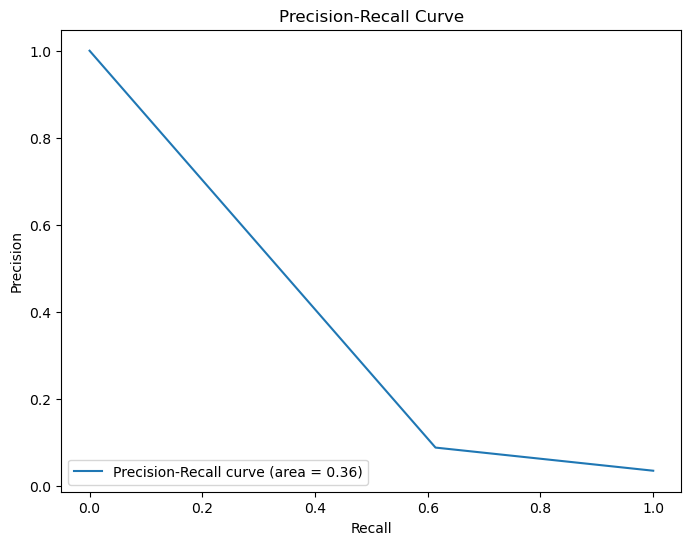

Can capture 61 % of fraud transactions and the prediction precision is 9 %. 23 % of non-fraud transactions are misclassified


In [76]:
#| code-fold: true
evaluate_results(y_test, y_pred)

## 7-4. XGBoost

1. Change data type from int to object
    - _Weekdays
    - _Hours
    - _Days

2. Group low frequency values of addr1:
    - Avoid overfitting and curse of dimensionality

3. Set Date to index and sort ascending:
    - for time series data, it's better to split by time to make sure training data is older than test data, which is different from normal train test split.

4. One hot encoding:
    - _Weekdays
    - _Hours
    - _Days
    - ProductCD
    - card4
    - card6
    - addr1
    - P_emaildomain_bin
    - P_emaildomain_suffix

5. Standerdization:
    - TransactionAmt
    

6. Split data

7. Perform oversampling to solve imbalance problem:
    - Recall that in EDA of isFraud variable that fraud transactions occur far less frequently compared to non-fraudulent ones. To address this class imbalance, performing oversampling specifically on fraud transactions becomes crucial, allowing us to better capture and train the model on these rare instances.

8. Perform XGBoost

9. Evaluate Results:
    - Confusion Matrix
    - F1-score
    - Recall-Precision curve AUC

10. Conclusion:
    - The best model's precision-recall auc is 0.36, which can capture 59 % of fraud transactions and the prediction precision is 11 %. 17 % of non-fraud transactions are misclassified.

In [94]:
#| code-fold: true
# Selecting the specified columns
df_train = df_merged[selected_columns]
# 1. change data type from int to object
df_train[['_Weekdays', '_Hours', '_Days']] = df_train[['_Weekdays', '_Hours', '_Days']].astype('object')

# 2. Group low frequency values of addr1
df_train = group_low_percentage_values(df_train, 'addr1', threshold=1)

# 3. Set Date to index and sort ascending
df_train.set_index('Date', inplace=True)
df_train.sort_index(ascending=True, inplace=True)

# Splitting into features and target variable
X = df_train.drop('isFraud', axis=1)
y = df_train['isFraud']

# 4. One hot encoding
columns_to_encode = ['_Weekdays', '_Hours', '_Days', 'ProductCD', 'card4', 'card6','addr1', 'P_emaildomain_bin', 'P_emaildomain_suffix']
X_transformed = pd.get_dummies(X, columns=columns_to_encode, prefix=columns_to_encode)

# 5. Standerdization
columns_to_standerdize = ['TransactionAmt']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[columns_to_standerdize])
X_transformed['TransactionAmt'] = X_scaled

# 6. Split data
train_date = '2018-04-30'
test_date = '2018-05-01'
x_train, y_train, x_test, y_test = split_data_by_date(X_transformed, y, train_date, test_date)

# 7. oversampling
X=pd.concat([x_train,y_train],axis=1)
upsampled_data = upsample_minority_class(X)
x_train = upsampled.drop('isFraud', axis=1)
y_train = upsampled['isFraud']

In [78]:
#| code-fold: true
#8. Decision Tree
# Create XGBClassifier
clf = xgb.XGBClassifier(
            n_estimators=100, random_state=4, verbose=True, 
            tree_method='gpu_hist',objective='binary:logistic', max_depth=10, learning_rate=0.02, 
            subsample=0.8, colsample_bytree=0.4, eval_metric='aucpr'
        )

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
x_train_pred = clf.predict(x_train)
#Predict the response for test dataset
y_pred = clf.predict(x_test)


F1 Score: 0.7630705589039241
Confusion Matrix:
[[394996  85667]
 [131290 349373]]
Precision is 80 %; Recall is 73 %
PR-RC AUC: 0.8332553491374364


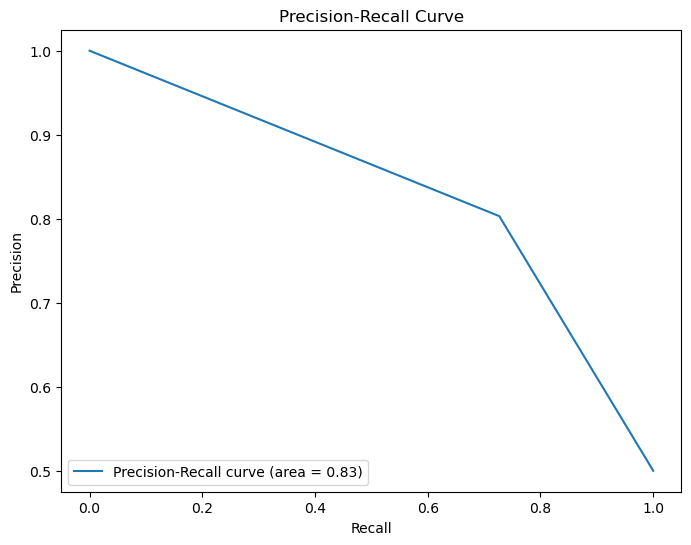

Can capture 73 % of fraud transactions and the prediction precision is 80 %. 18 % of non-fraud transactions are misclassified


In [79]:
#| code-fold: true
evaluate_results(y_train, x_train_pred)

F1 Score: 0.1855419342284491
Confusion Matrix:
[[73778 15436]
 [ 1306  1907]]
Precision is 11 %; Recall is 59 %
PR-RC AUC: 0.35880713885797433


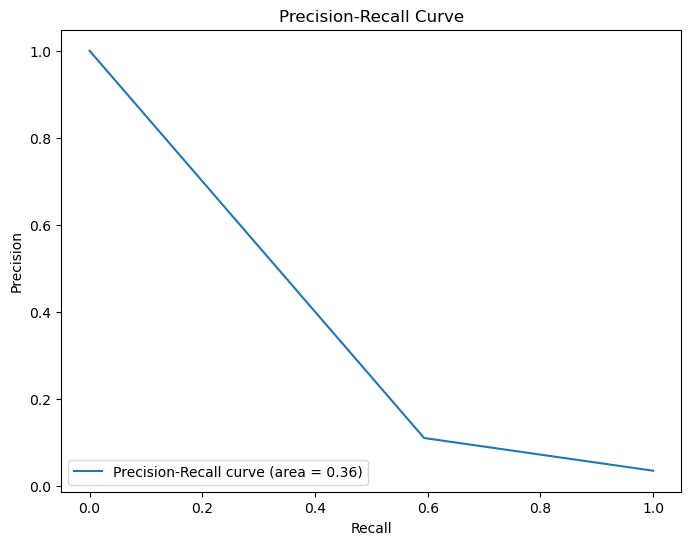

Can capture 59 % of fraud transactions and the prediction precision is 11 %. 17 % of non-fraud transactions are misclassified


In [80]:
#| code-fold: true
evaluate_results(y_test, y_pred)

## 7-5. Conclusion

Until now, we have experimented with three models (logistic regression, decision tree, xgboost); however, there has been no significant improvement in results. I suspect that the lack of improvement may not be due to the models' capabilities but rather a result of not utilizing the most informative features. The excluded features, such as C, D, M, and V, may contain some useful information, but their true meaning were not provided which give no meaningful insights. Therefore, we will not delve deeper into analyzing these features.

# 8. Conclusion

In this project, we discuss about several topics:

- Selection between ROC Curve and Precision-Recall Curve

- Features EDA

- Oversampling Technique

- Logistic Regression/ Decision Tree/ XGboost

The best model achieves a PR-RC AUC of 0.83 on the training data but only 0.37 on the testing data. This discrepancy does not stem from overfitting but rather from a deficiency in powerful predictive features. Specifically, certain features (C, D, M, and V) lack explicit meanings, hindering their ability to contribute meaningfully to the model's predictions.

Despite these challenges, the project remains fruitful, showcasing the application of various techniques and methodologies.